In [21]:
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision

import numpy as np
import matplotlib.pyplot as plt

import torch_networks as networks
import torch_loss_functions as lf

from data_loader import DataSetFor2DSegmentation, GroupWiseSplit

from original_transforms import add_axis

transform = torchvision.transforms.Compose([torchvision.transforms.Lambda(add_axis)])


spleen = GroupWiseSplit(target_volume="spleen", val_ratio=0.3, group_shuffle=False)
spleen_train = DataSetFor2DSegmentation(spleen.train_groups, target_focus=True, transform=transform)
spleen_val = DataSetFor2DSegmentation(spleen.val_groups, target_focus=True, transform=transform)

# パラメータ設定
train_size = len(spleen_train)
val_size = len(spleen_val)
channels = 1
width = 320
height = 320
epoch_n = 100
batchsize = 10

train_loader = DataLoader(spleen_train, batch_size=batchsize, shuffle=True)
val_loader = DataLoader(spleen_val, batch_size=batchsize)

In [22]:
def img_output(inference,  p=0.5, ant=False, gpu_id=-1):
    # 入力は2チャンネルのVariable
    inference = inference.data[0] # 最後の一枚の１チャンネル目
    
    inference = inference * 255
    threshold = 255 * p

    if ant==False:
        mask255 = inference > threshold
        inference[mask255] = 255

        mask0 = inference <= threshold
        inference[mask0] = 0
    else:
        mask0 = inference > threshold
        inference[mask0] = 0

        mask255 = inference != 0
        inference[mask255] = 255
    
        output = inference

    return output


if torch.cuda.is_available():
    gpu_id = 0
    device = torch.device("cuda:" + str(gpu_id))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch1
train_loss:tensor(1.4171, device='cuda:0')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:56: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


val_loss:tensor(1.4351, device='cuda:0')
epoch2
train_loss:tensor(1.3871, device='cuda:0')
val_loss:tensor(1.4223, device='cuda:0')
epoch3
train_loss:tensor(1.3777, device='cuda:0')
val_loss:tensor(1.4098, device='cuda:0')
epoch4
train_loss:tensor(1.3703, device='cuda:0')
val_loss:tensor(1.4016, device='cuda:0')
epoch5
train_loss:tensor(1.3640, device='cuda:0')
val_loss:tensor(1.3975, device='cuda:0')
epoch6
train_loss:tensor(1.3581, device='cuda:0')
val_loss:tensor(1.4013, device='cuda:0')
epoch7
train_loss:tensor(1.3529, device='cuda:0')
val_loss:tensor(1.3873, device='cuda:0')
epoch8
train_loss:tensor(1.3491, device='cuda:0')
val_loss:tensor(1.3893, device='cuda:0')
epoch9
train_loss:tensor(1.3452, device='cuda:0')
val_loss:tensor(1.3805, device='cuda:0')
epoch10
train_loss:tensor(1.3418, device='cuda:0')
val_loss:tensor(1.3762, device='cuda:0')
epoch11
train_loss:tensor(1.3392, device='cuda:0')
val_loss:tensor(1.3733, device='cuda:0')
epoch12
train_loss:tensor(1.3371, device='cuda:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


val_loss:tensor(1.3649, device='cuda:0')
epoch22
train_loss:tensor(1.3257, device='cuda:0')
val_loss:tensor(1.3654, device='cuda:0')
epoch23
train_loss:tensor(1.3254, device='cuda:0')
val_loss:tensor(1.3639, device='cuda:0')
epoch24
train_loss:tensor(1.3246, device='cuda:0')
val_loss:tensor(1.3581, device='cuda:0')
epoch25
train_loss:tensor(1.3244, device='cuda:0')
val_loss:tensor(1.3606, device='cuda:0')
epoch26
train_loss:tensor(1.3245, device='cuda:0')
val_loss:tensor(1.3592, device='cuda:0')
epoch27
train_loss:tensor(1.3236, device='cuda:0')
val_loss:tensor(1.3582, device='cuda:0')
epoch28
train_loss:tensor(1.3235, device='cuda:0')
val_loss:tensor(1.4020, device='cuda:0')
epoch29
train_loss:tensor(1.3234, device='cuda:0')
val_loss:tensor(1.3670, device='cuda:0')
epoch30
train_loss:tensor(1.3230, device='cuda:0')
val_loss:tensor(1.3650, device='cuda:0')
epoch31
train_loss:tensor(1.3229, device='cuda:0')
val_loss:tensor(1.3635, device='cuda:0')
epoch32
train_loss:tensor(1.3228, devic

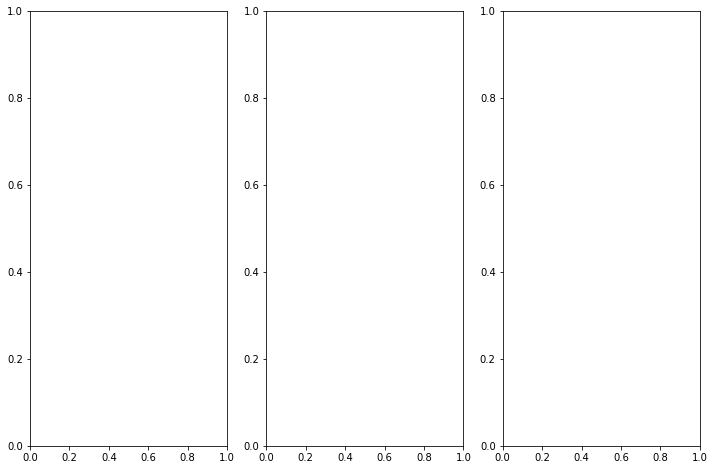

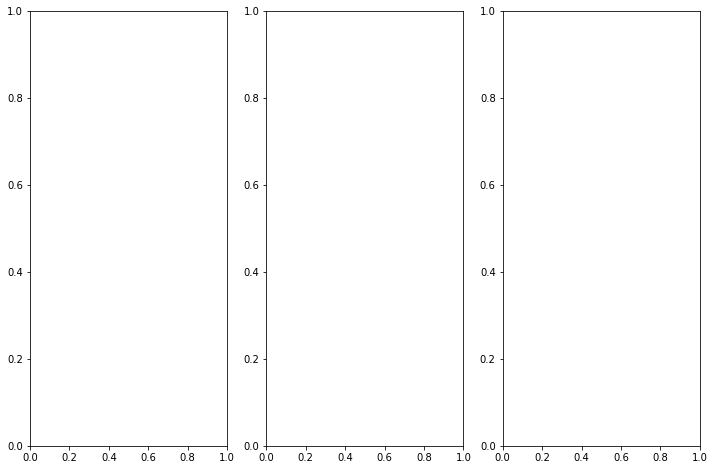

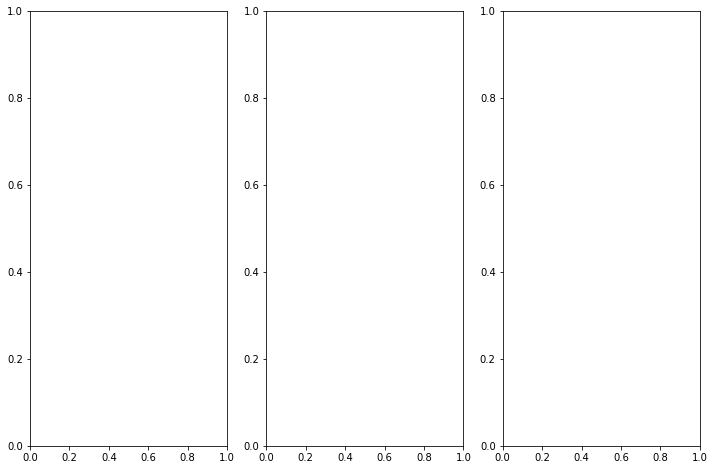

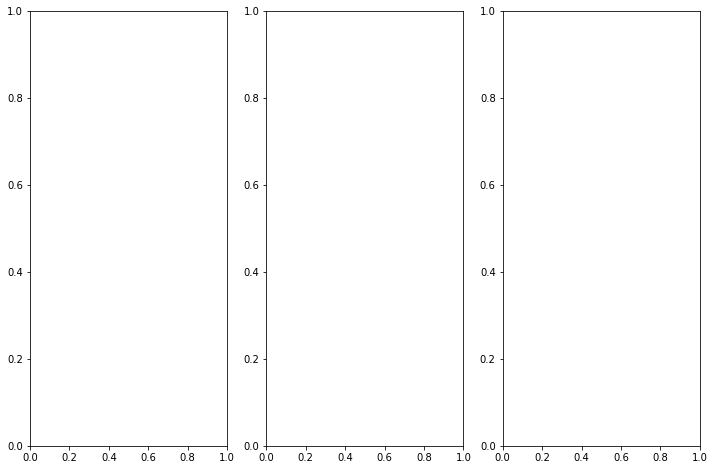

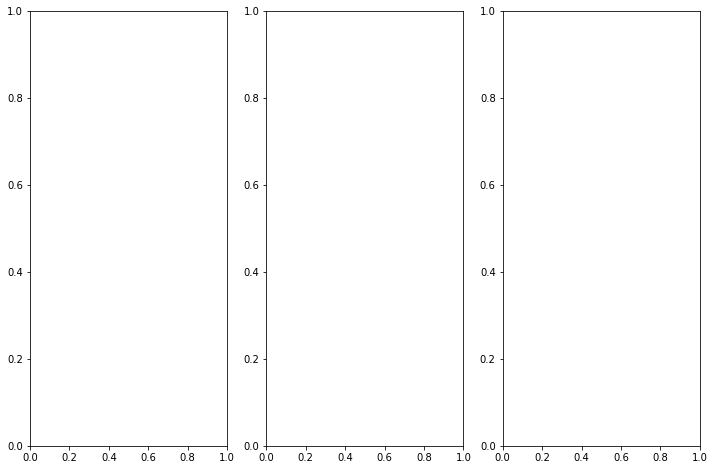

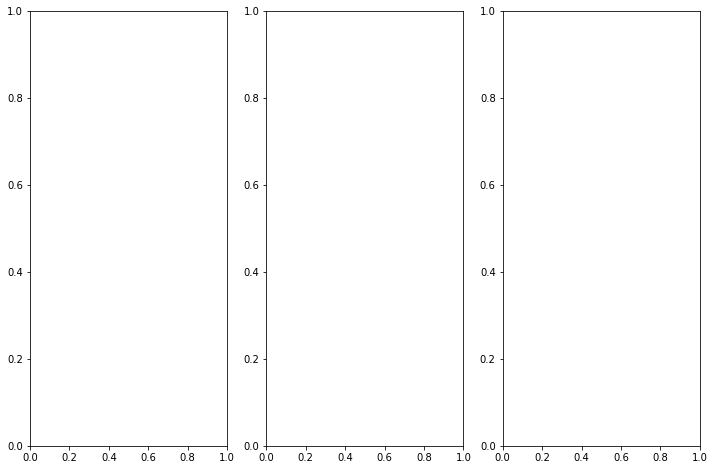

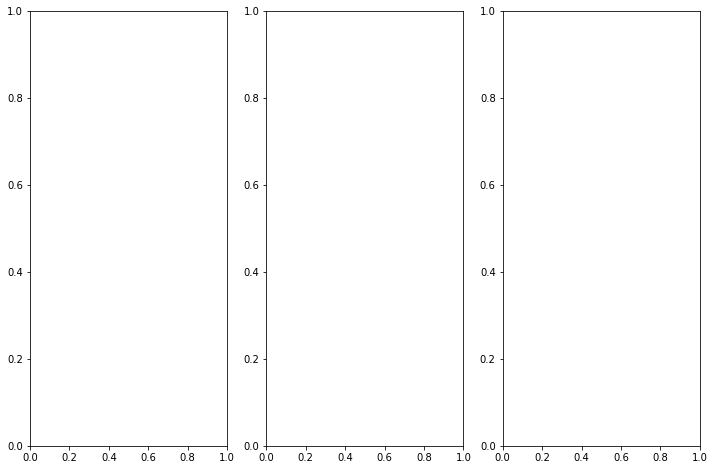

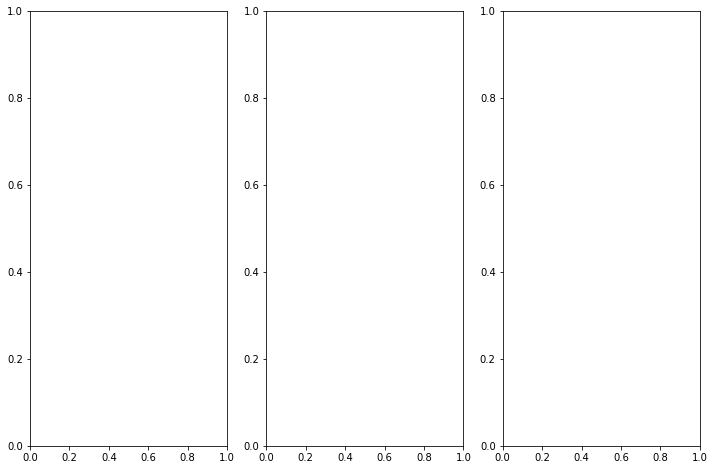

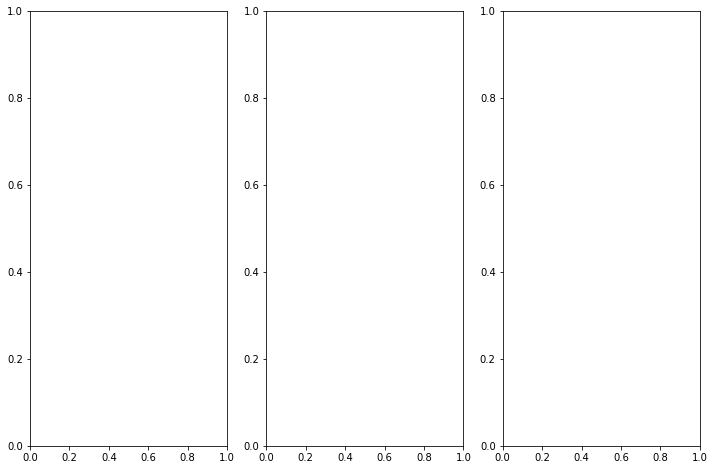

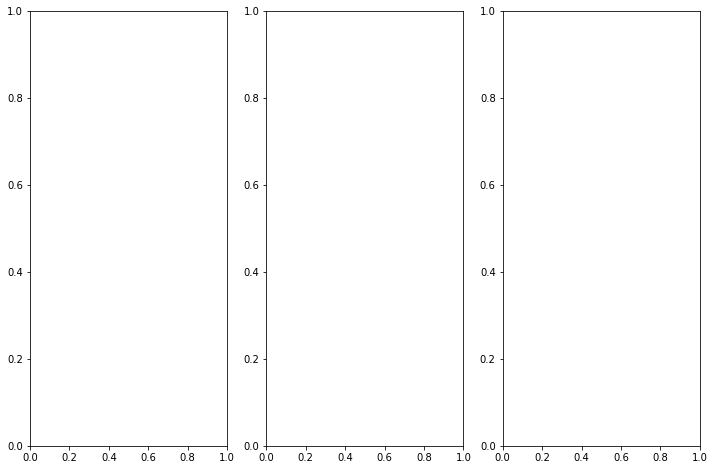

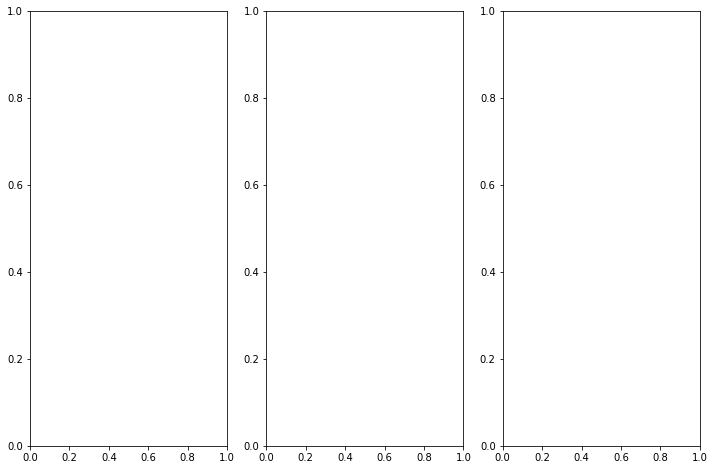

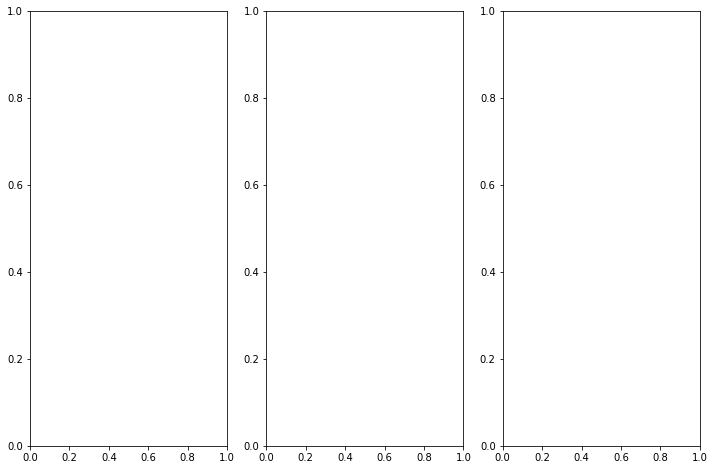

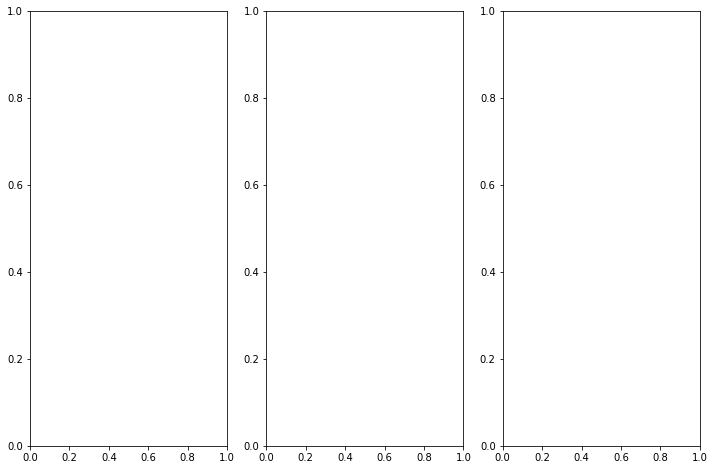

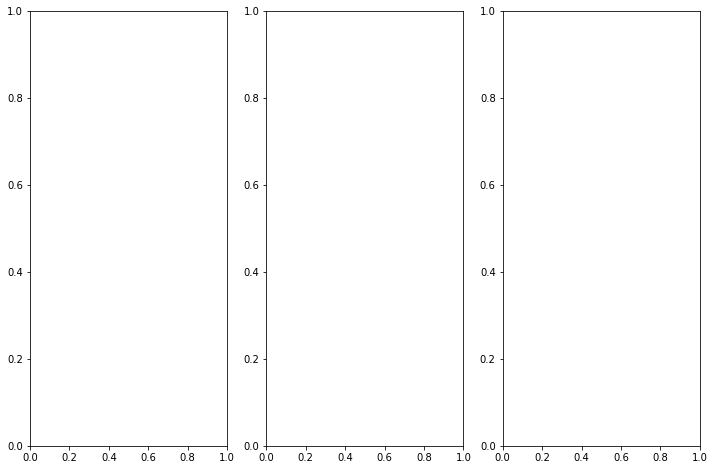

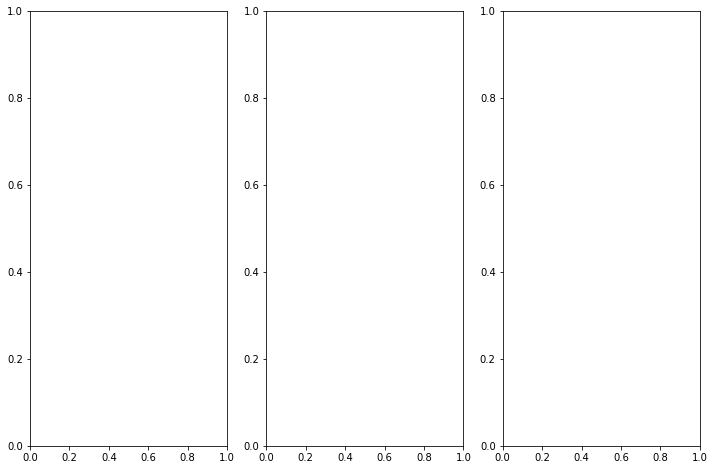

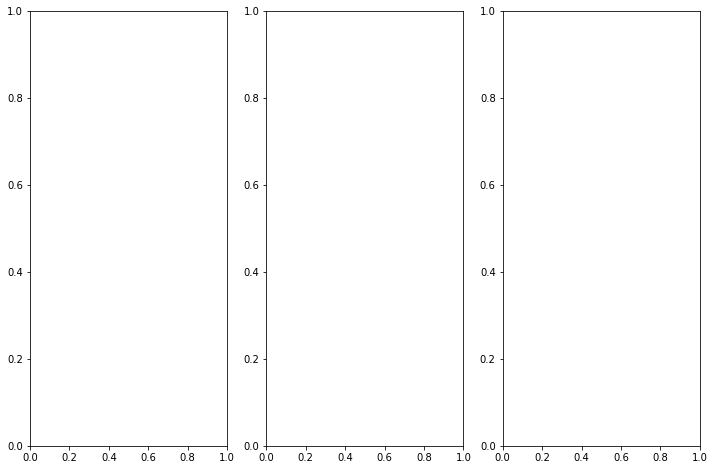

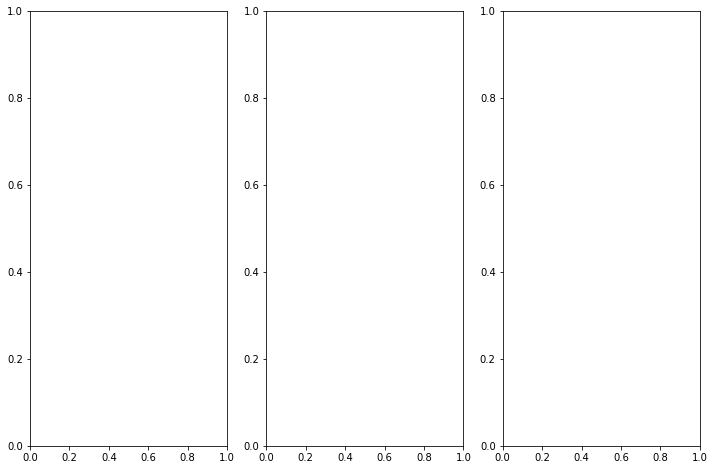

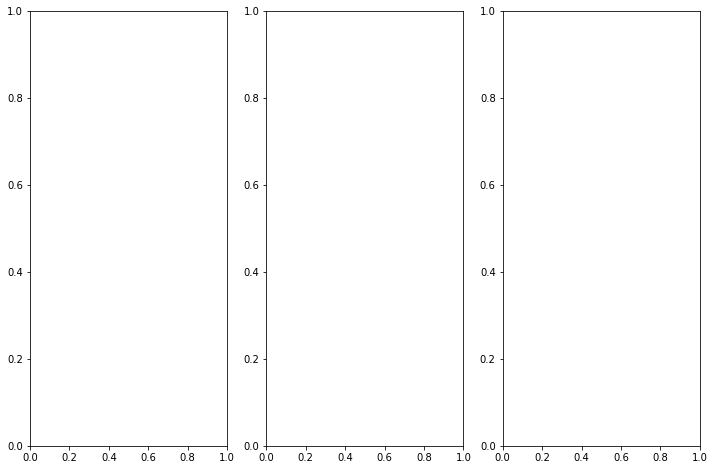

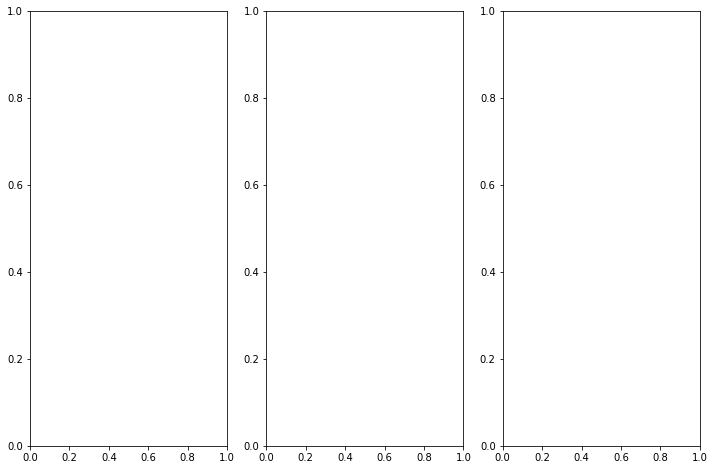

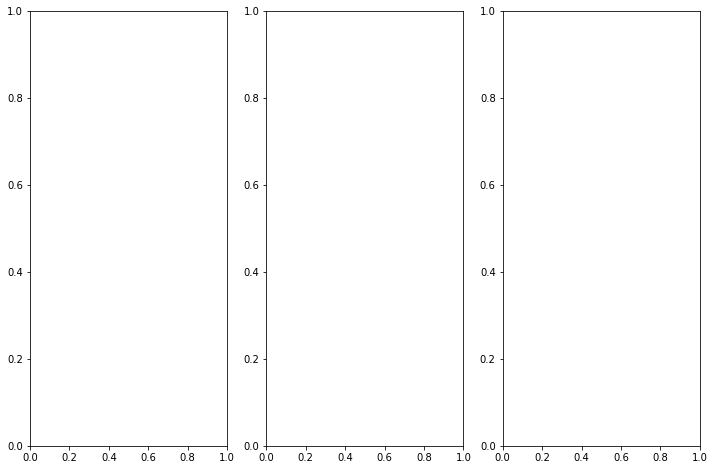

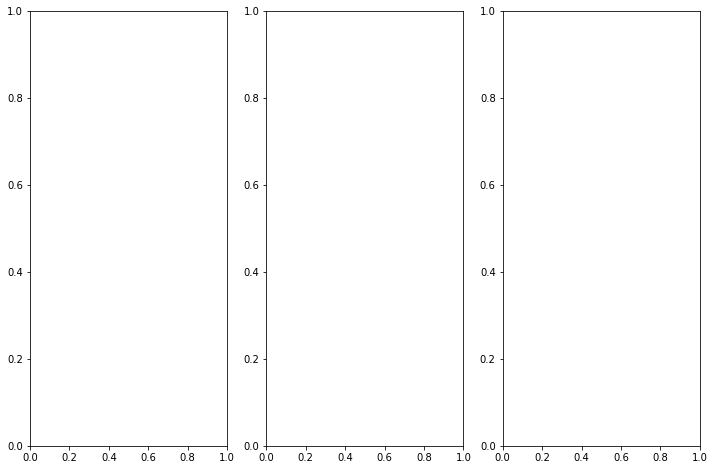

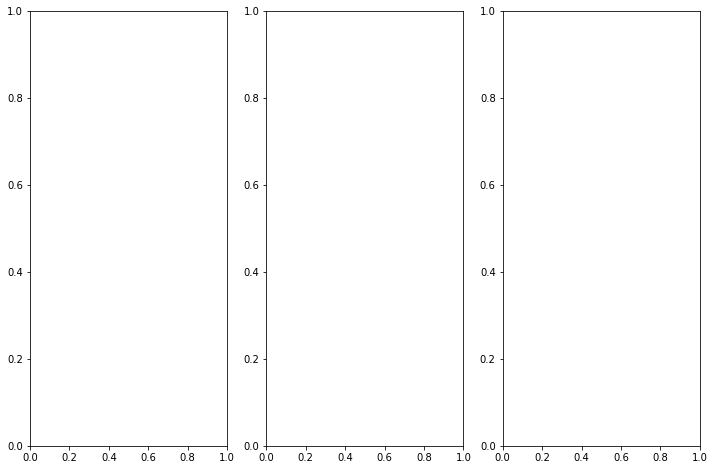

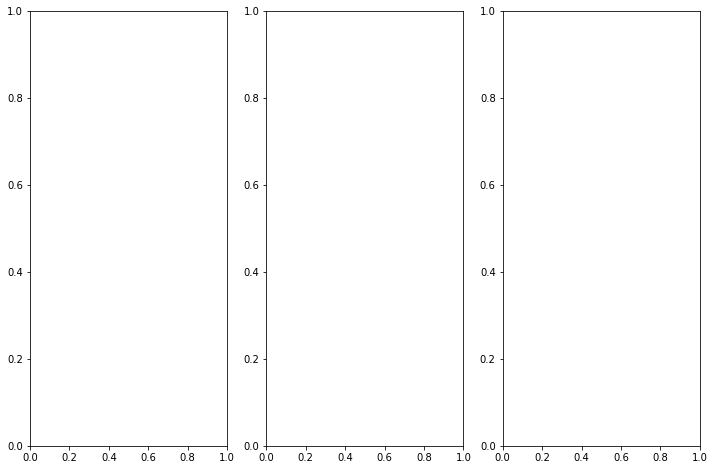

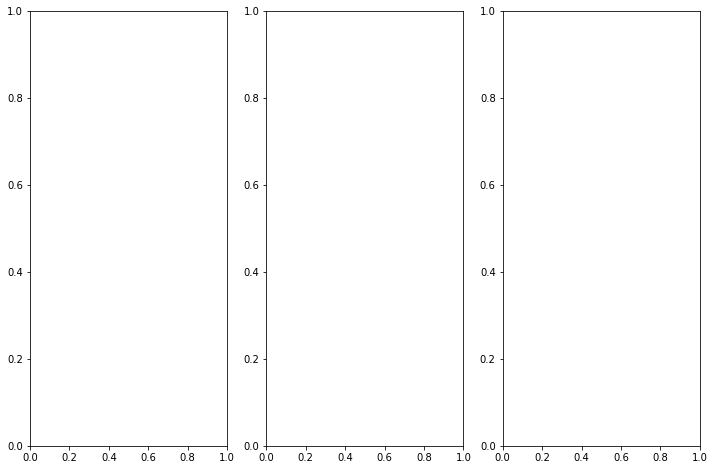

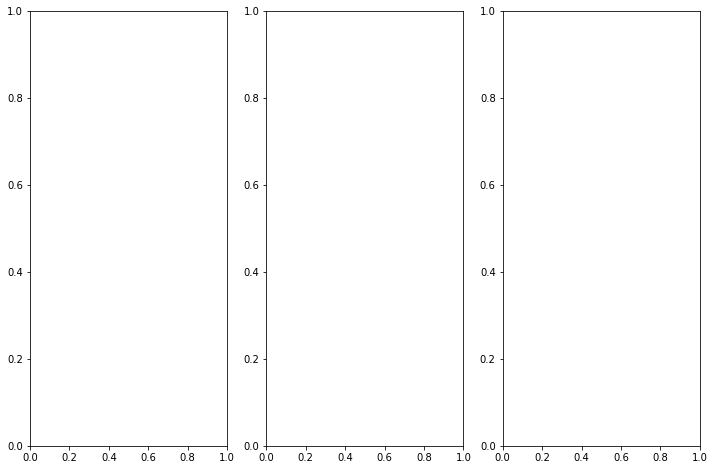

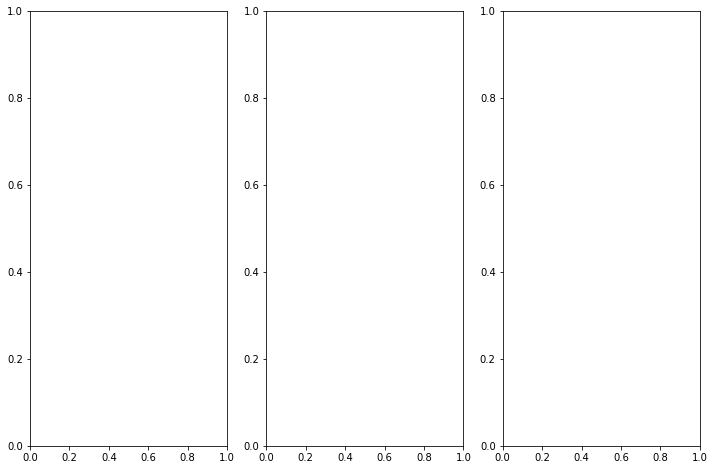

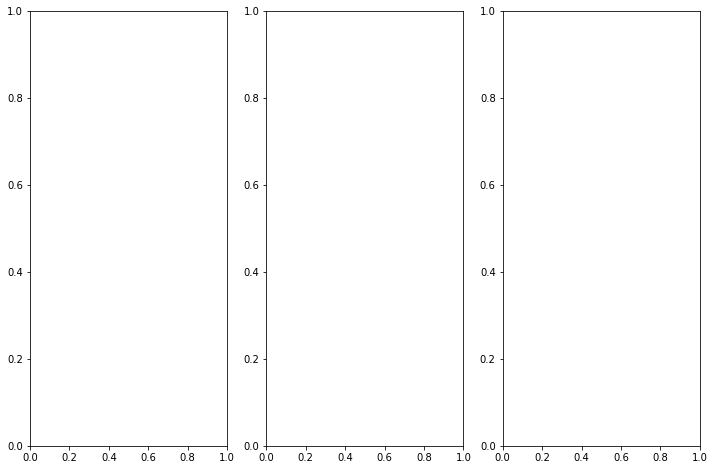

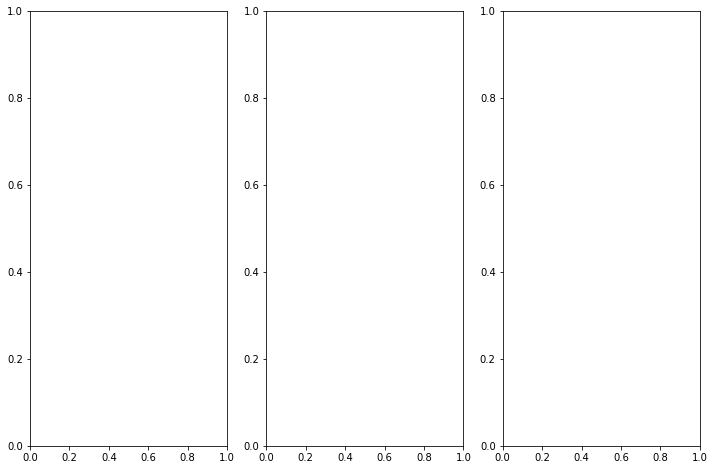

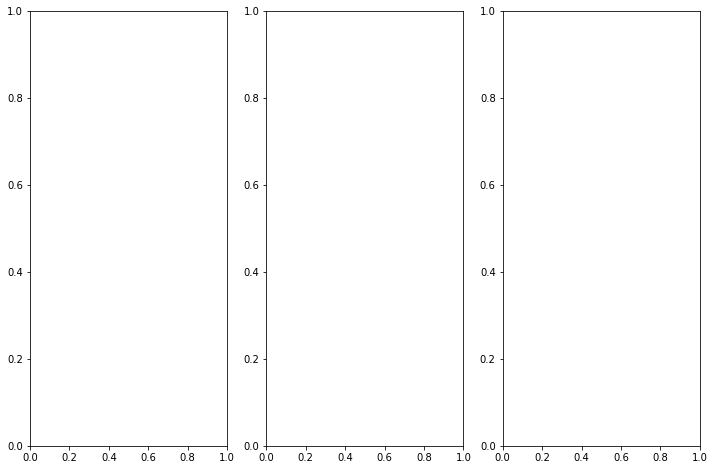

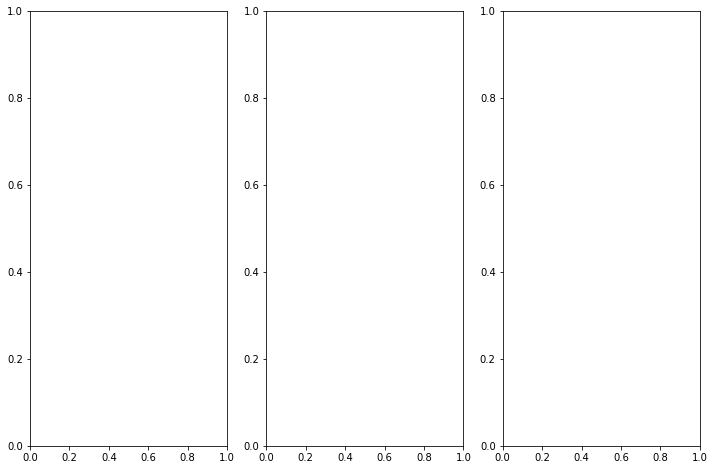

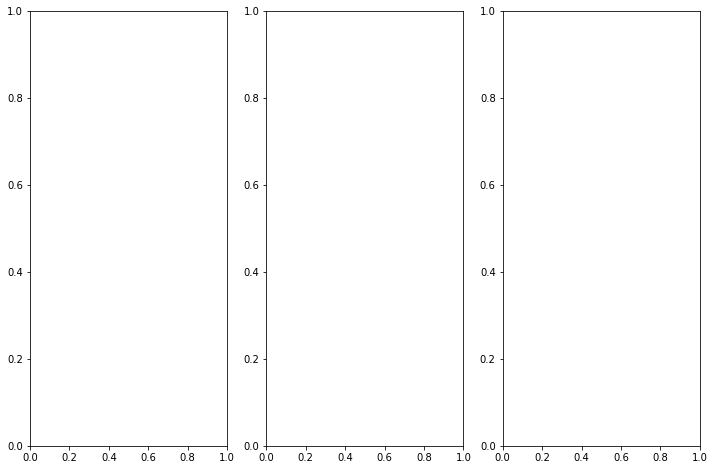

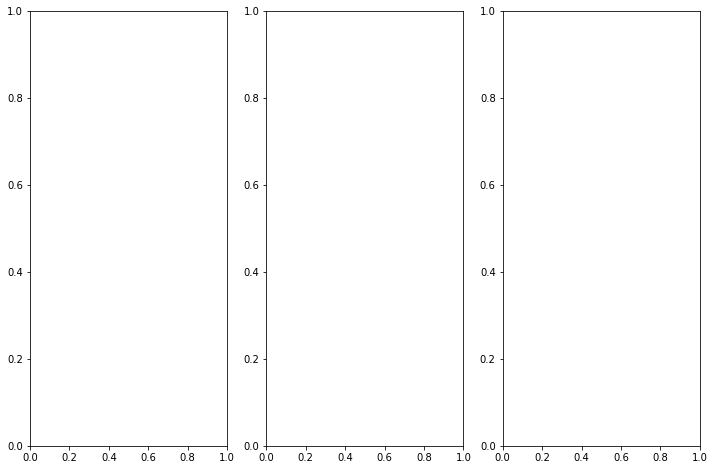

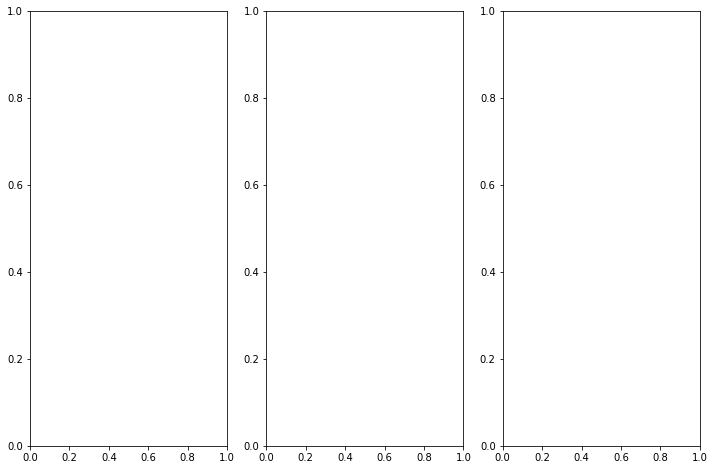

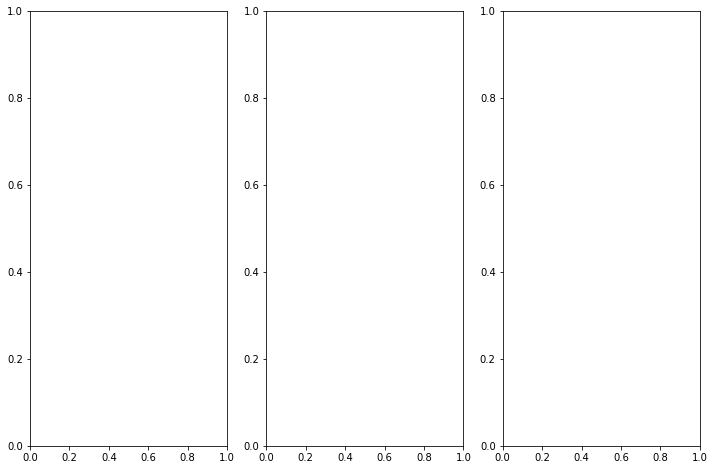

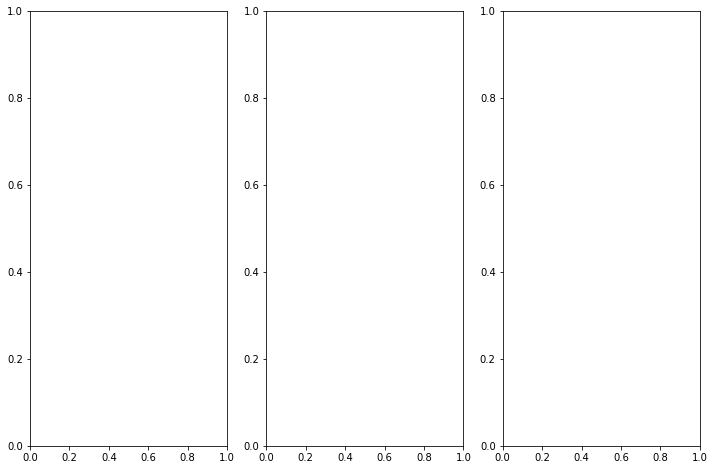

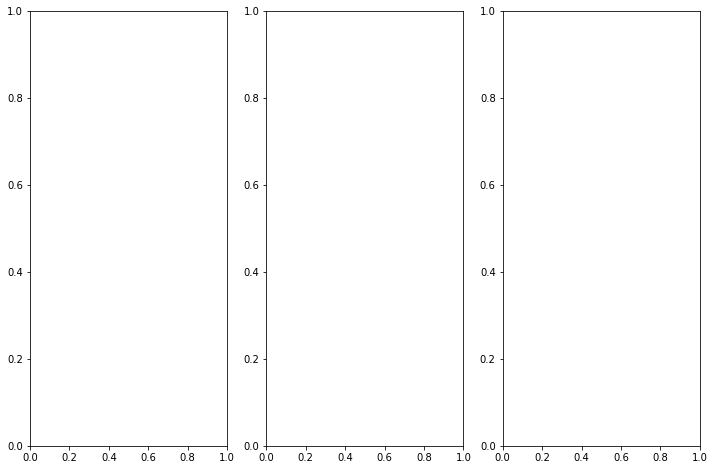

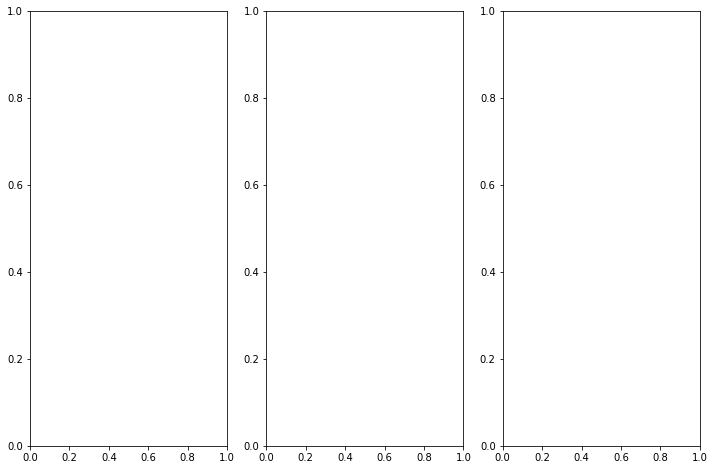

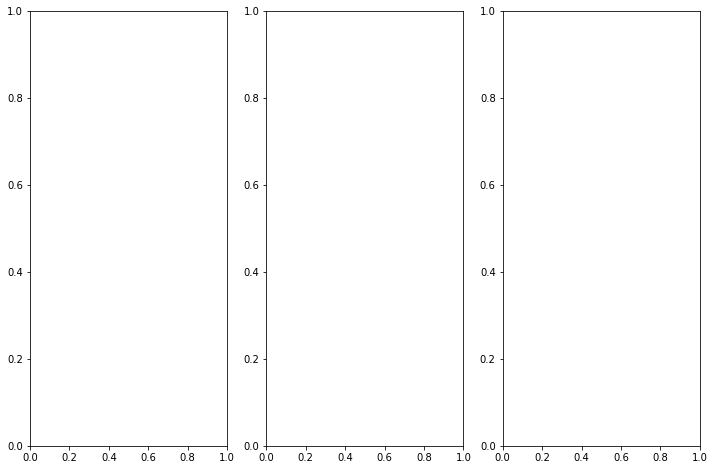

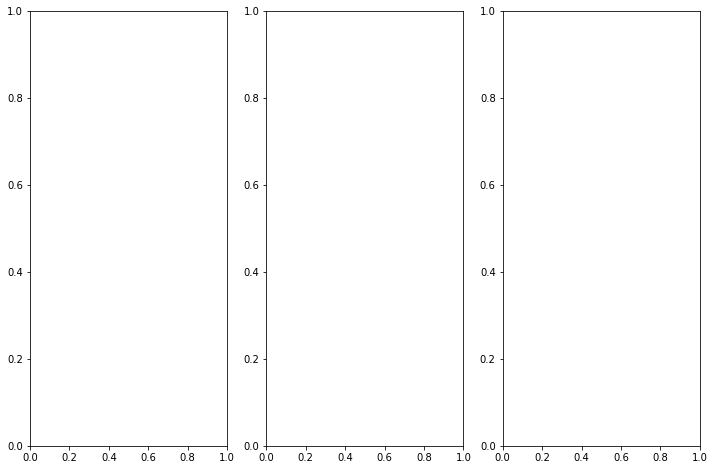

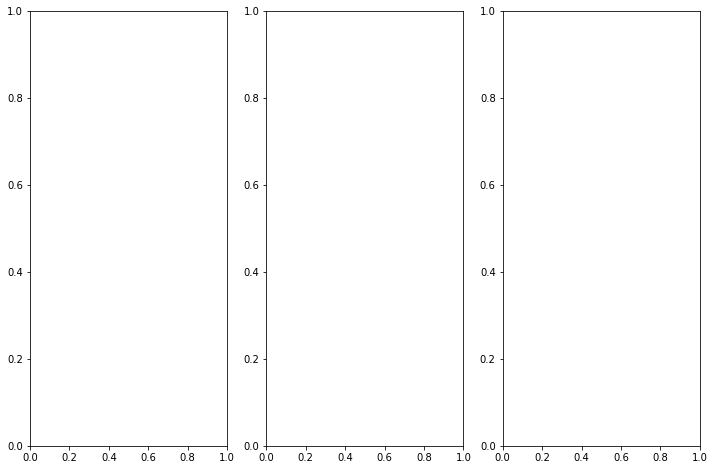

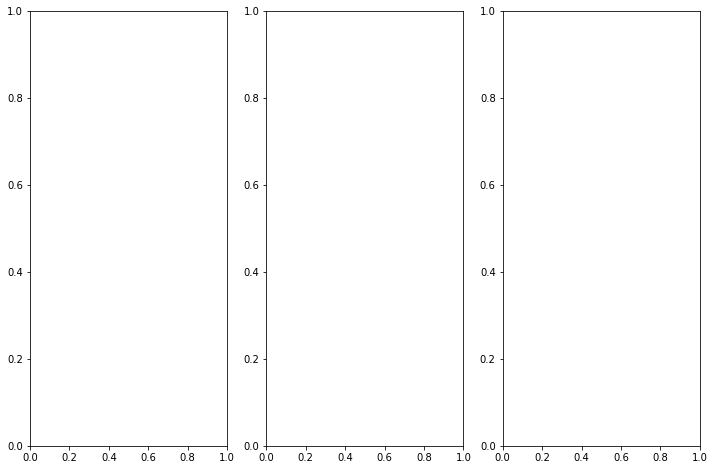

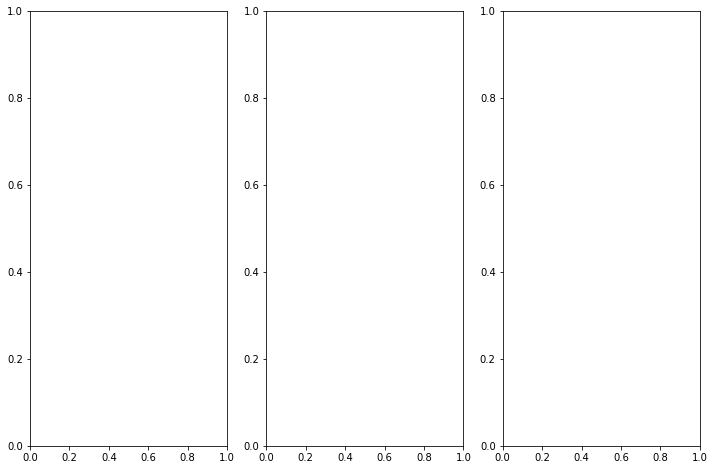

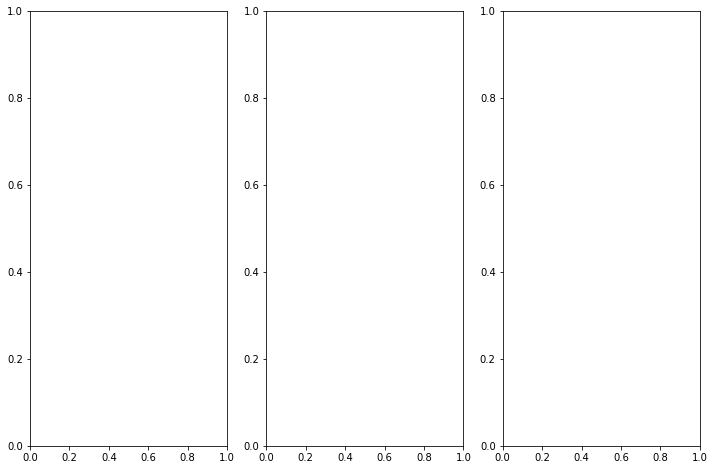

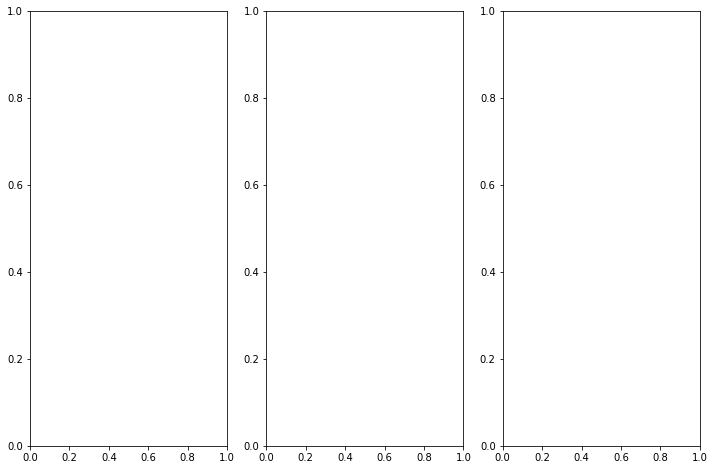

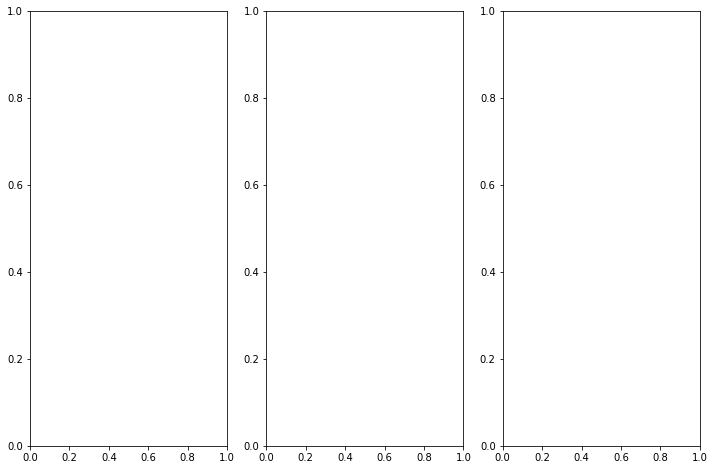

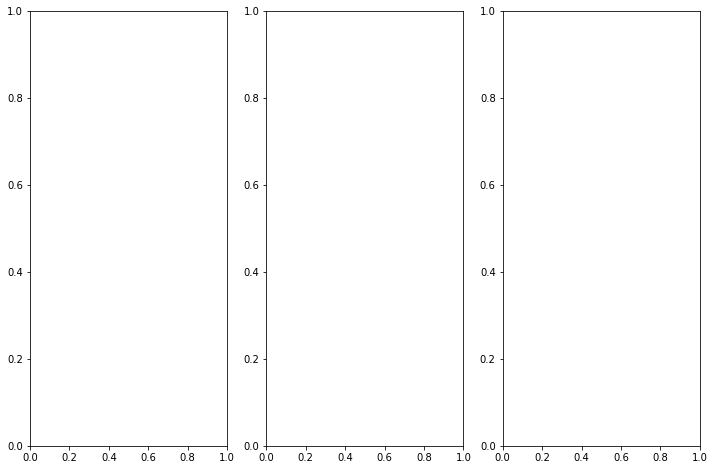

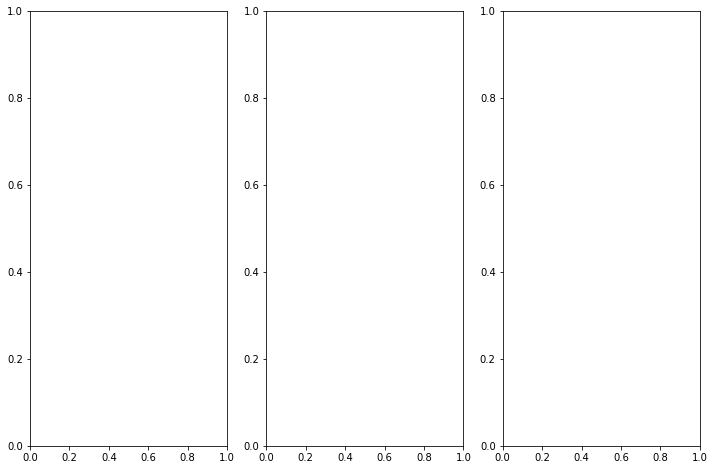

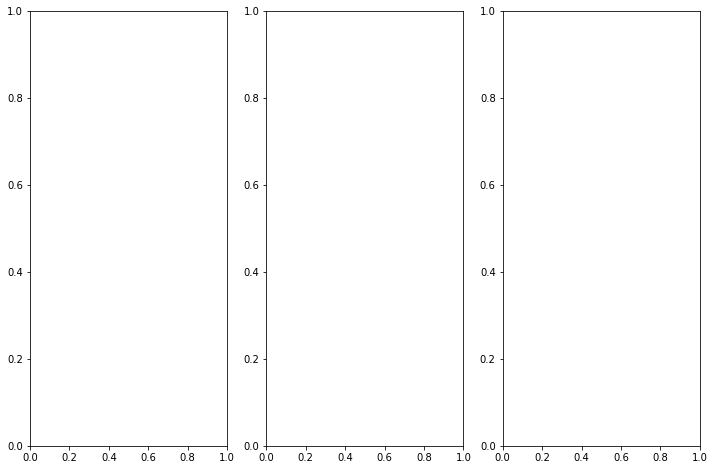

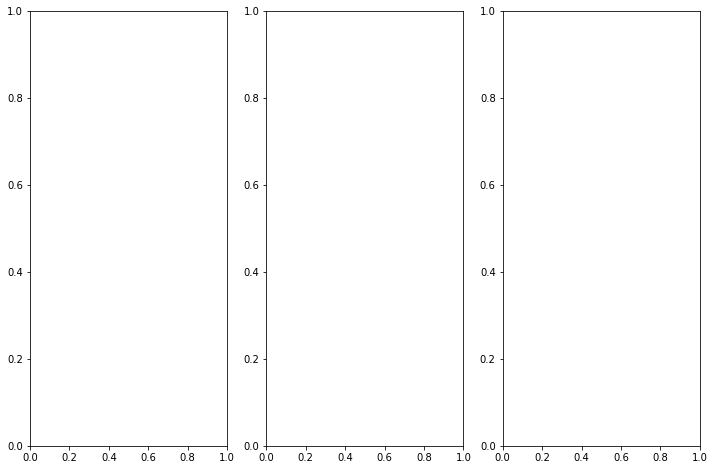

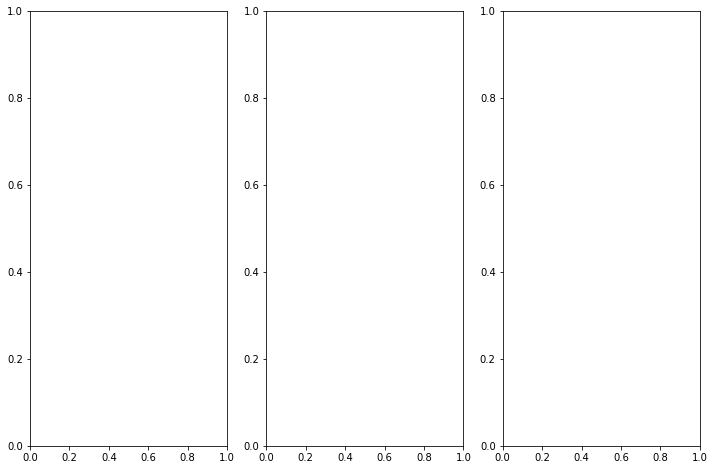

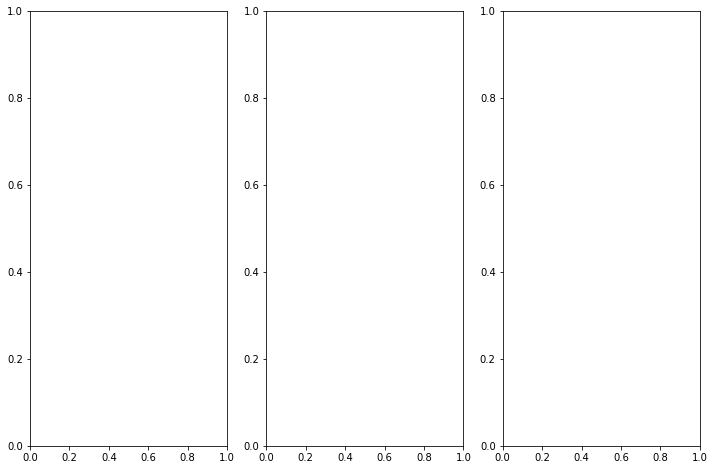

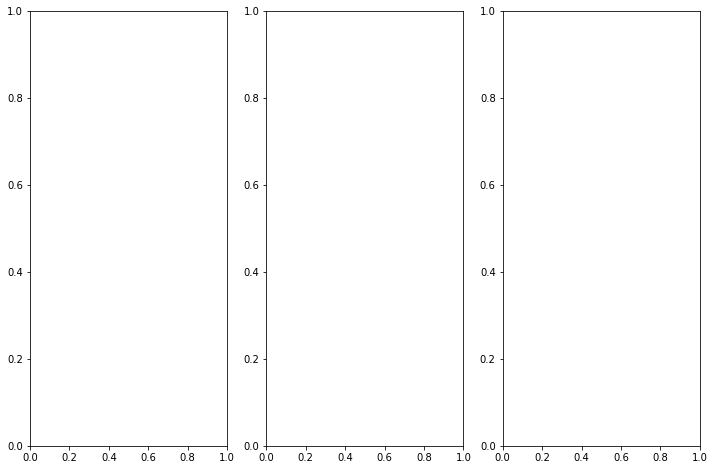

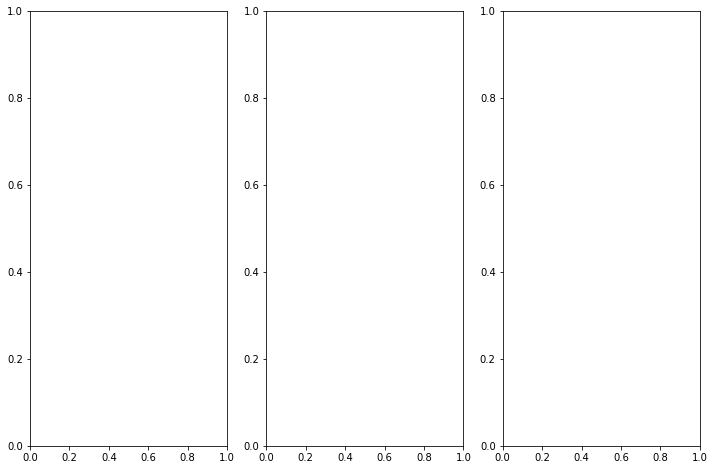

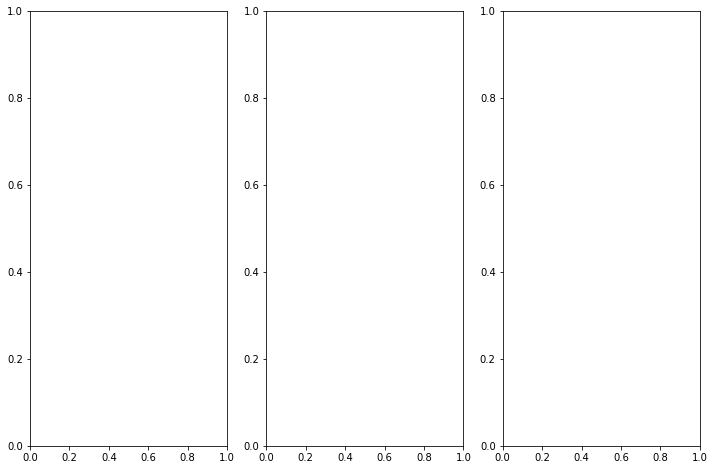

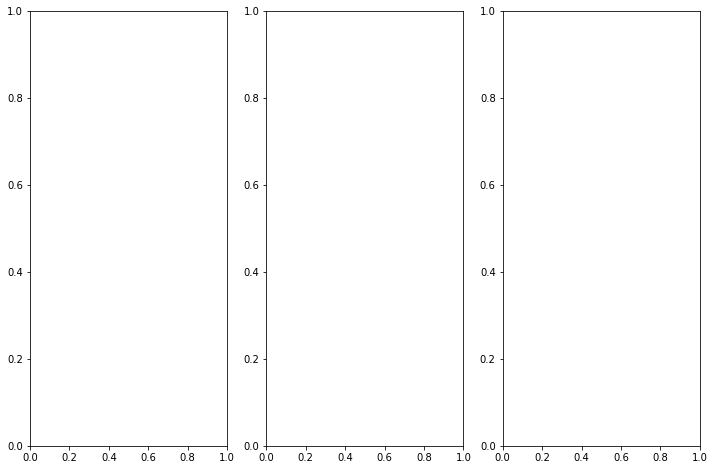

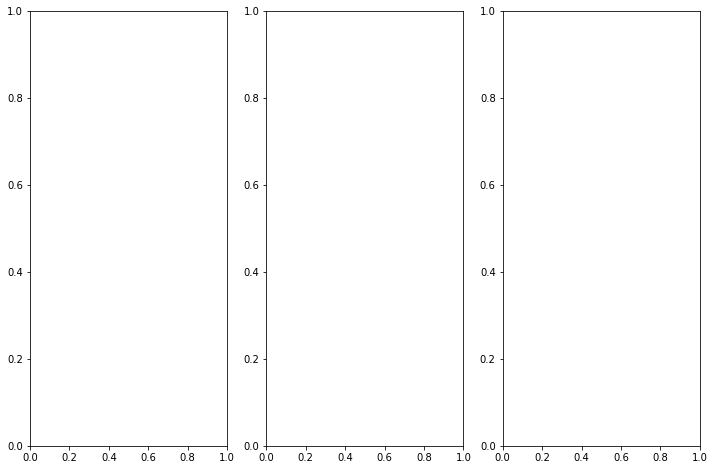

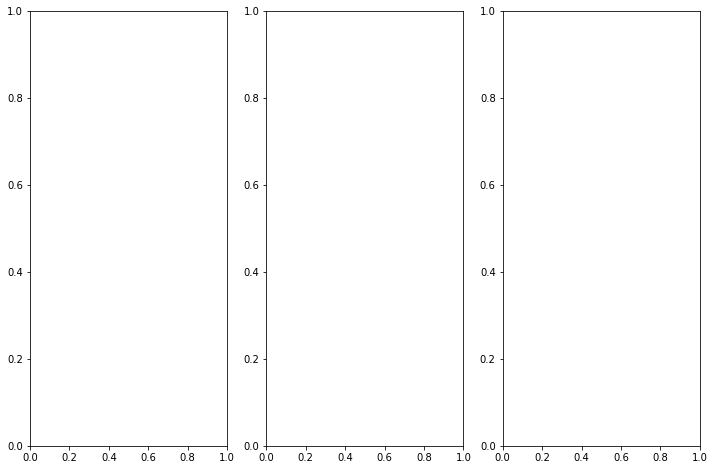

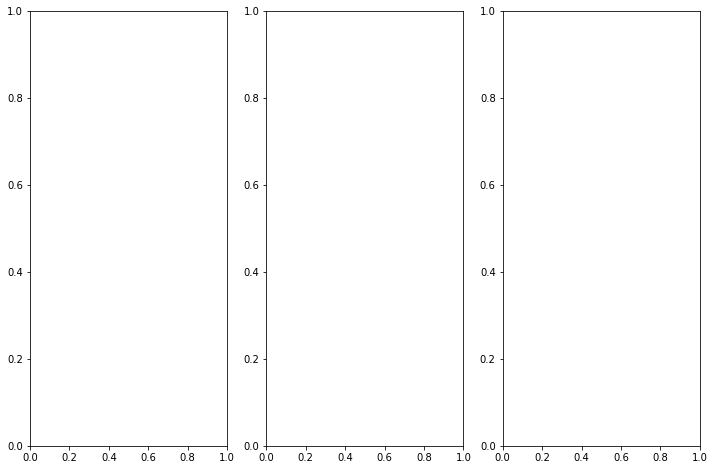

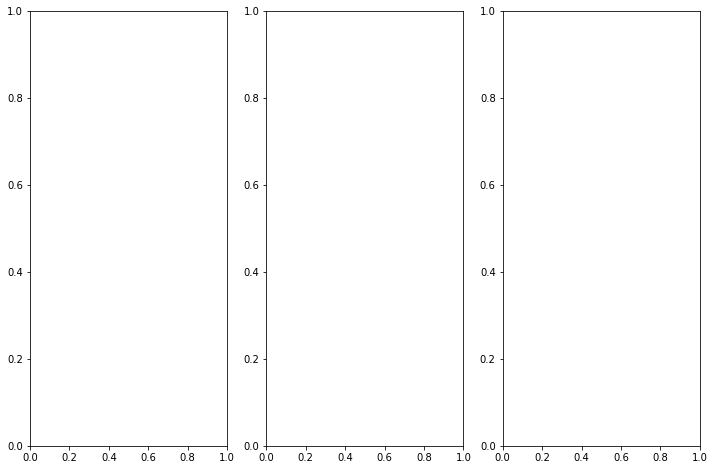

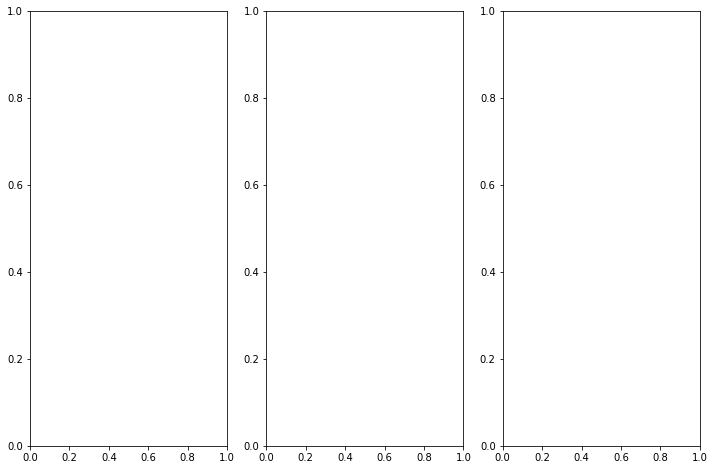

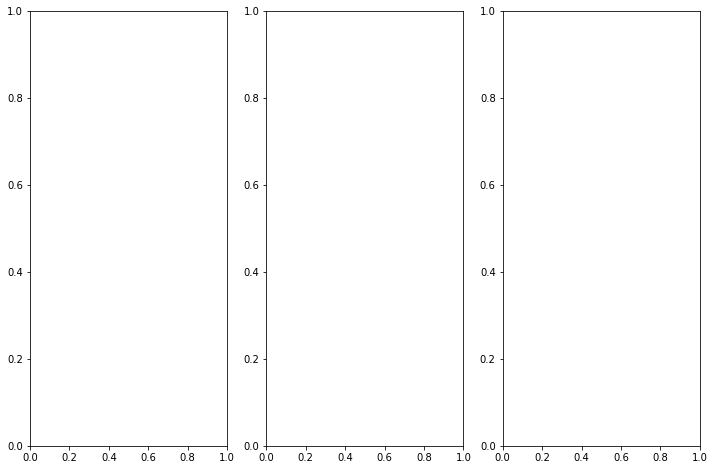

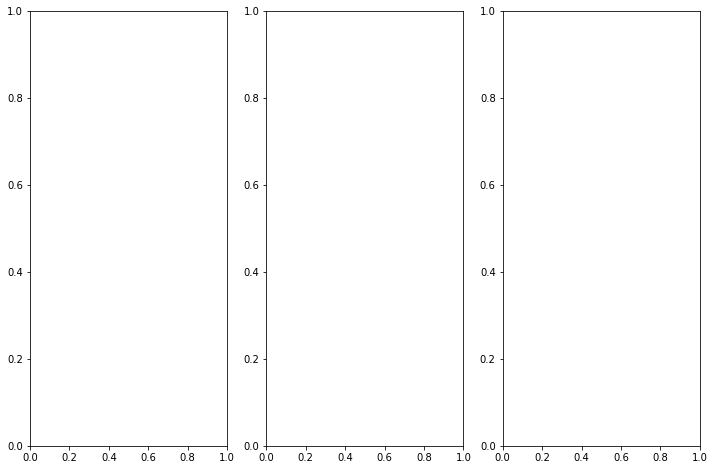

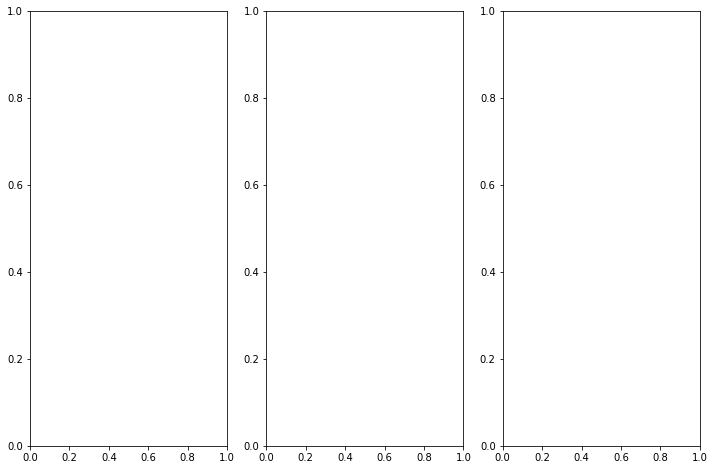

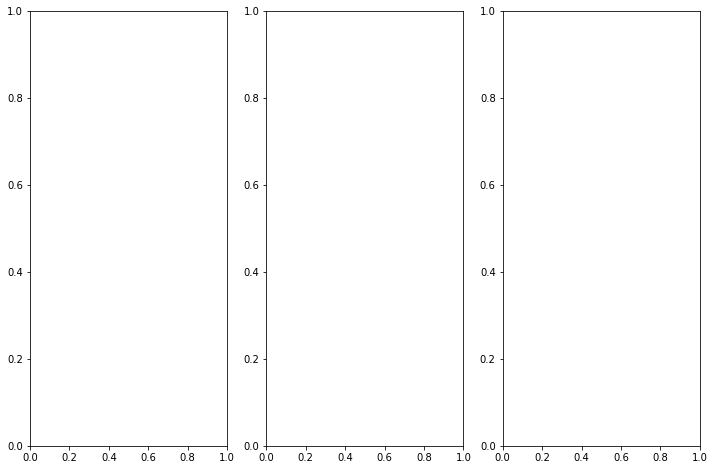

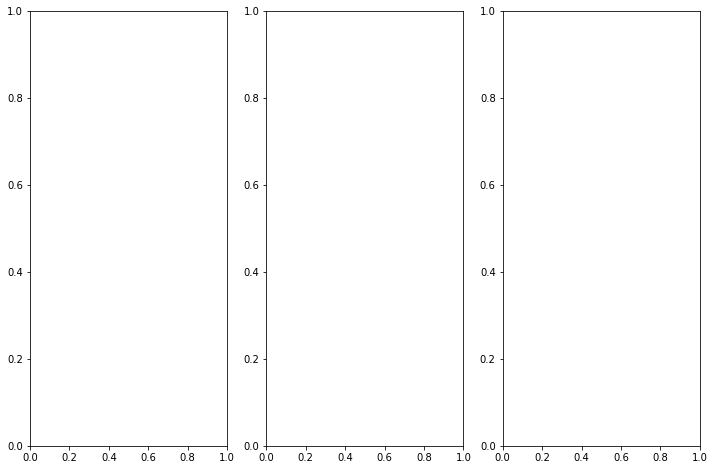

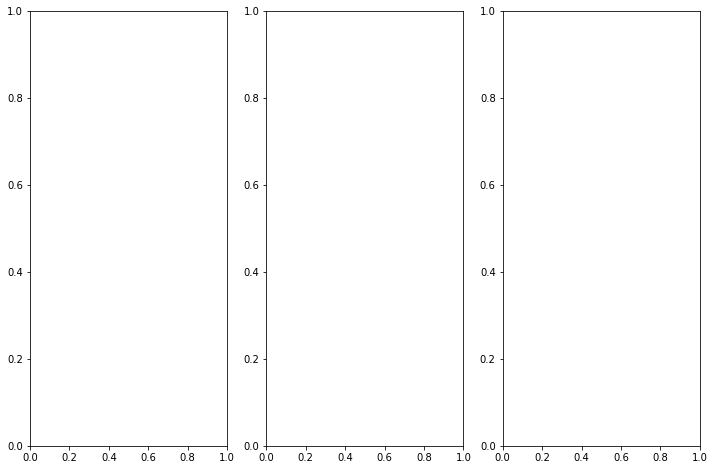

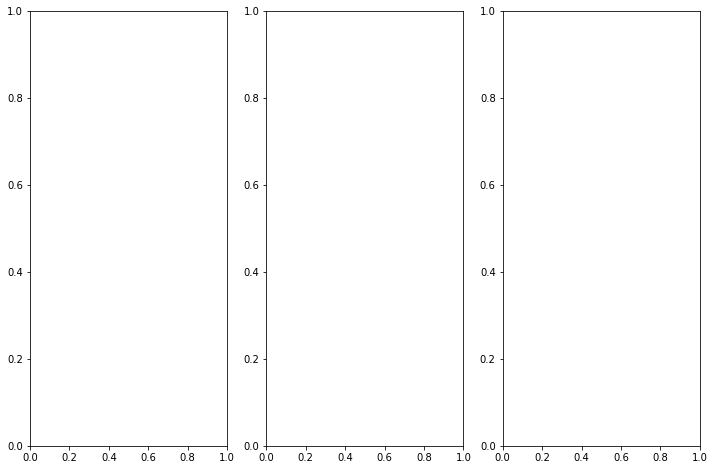

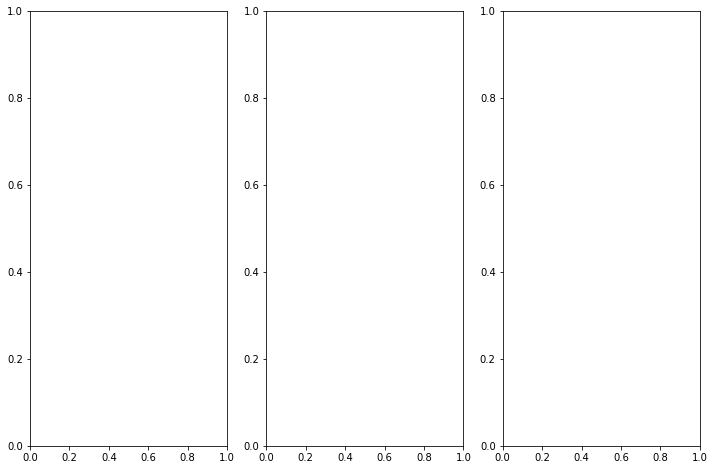

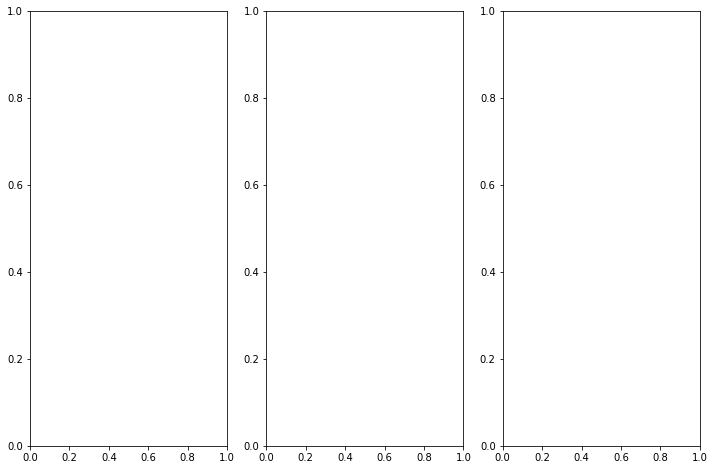

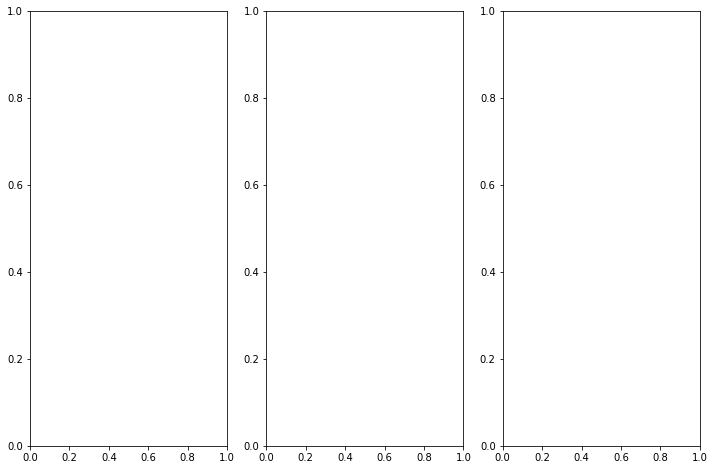

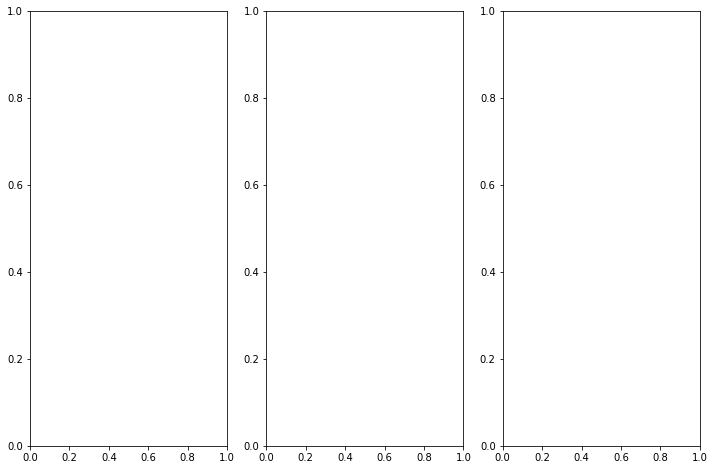

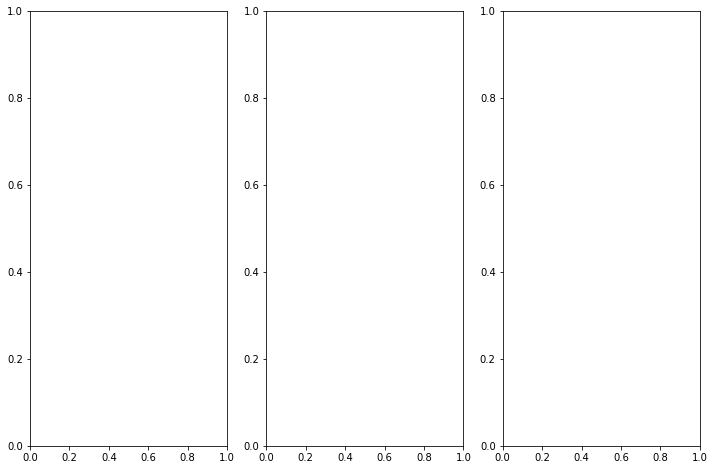

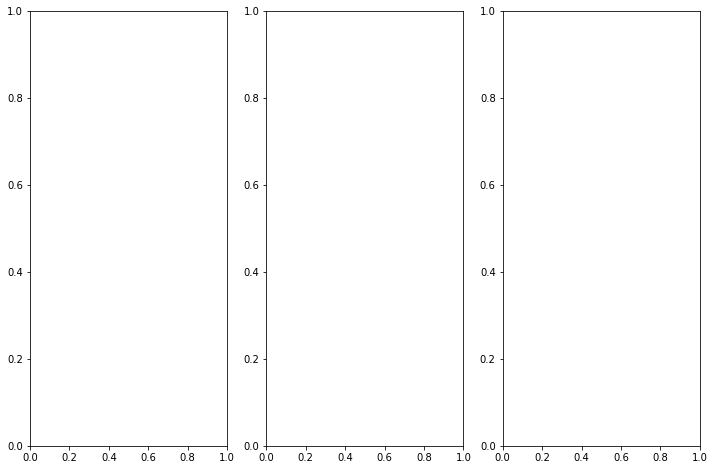

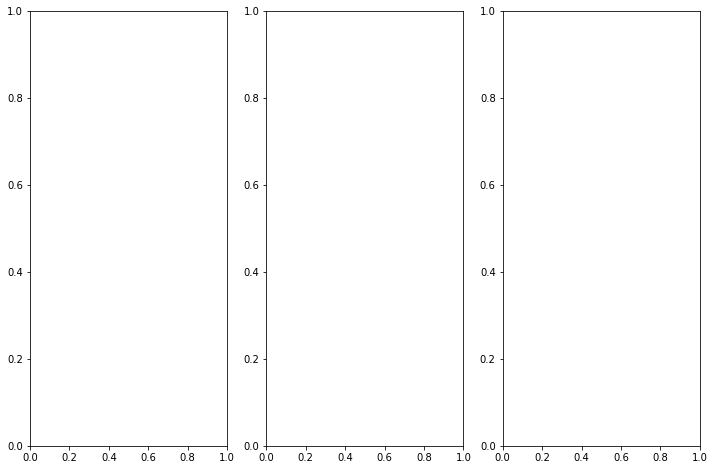

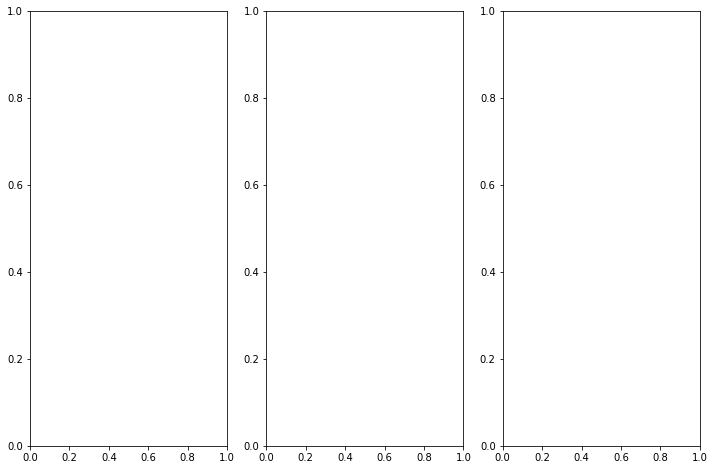

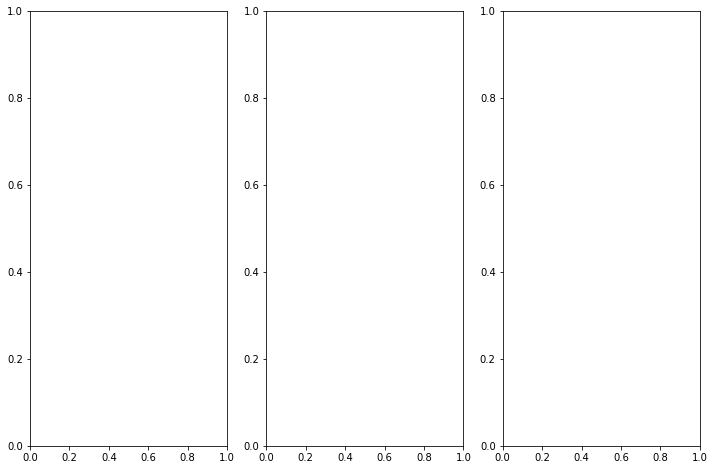

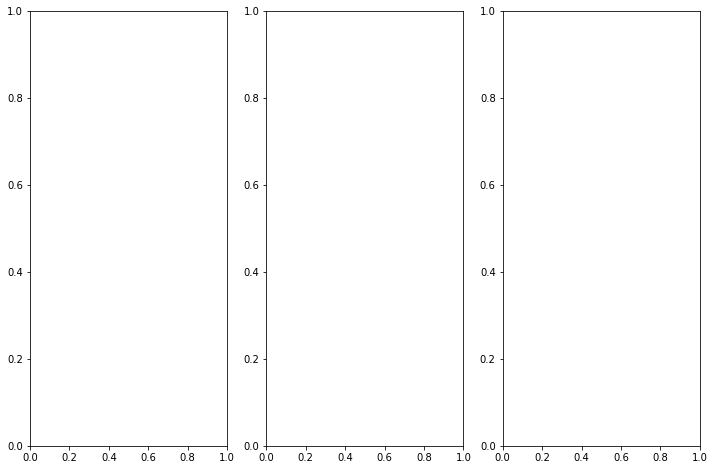

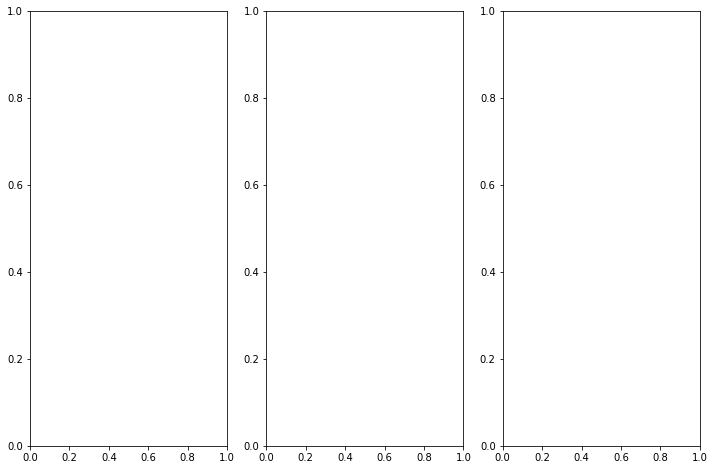

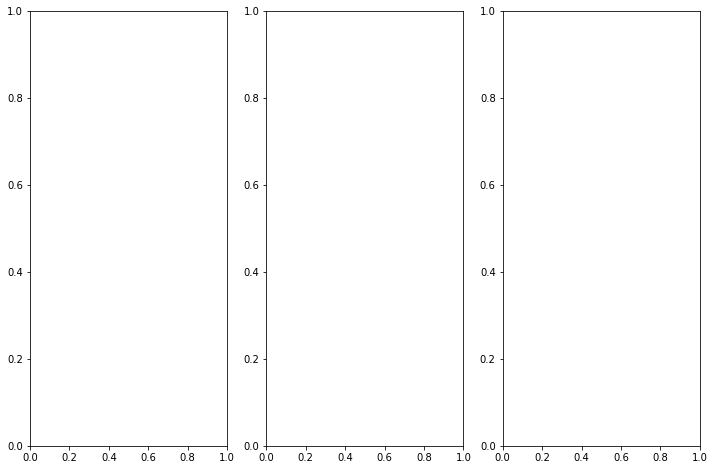

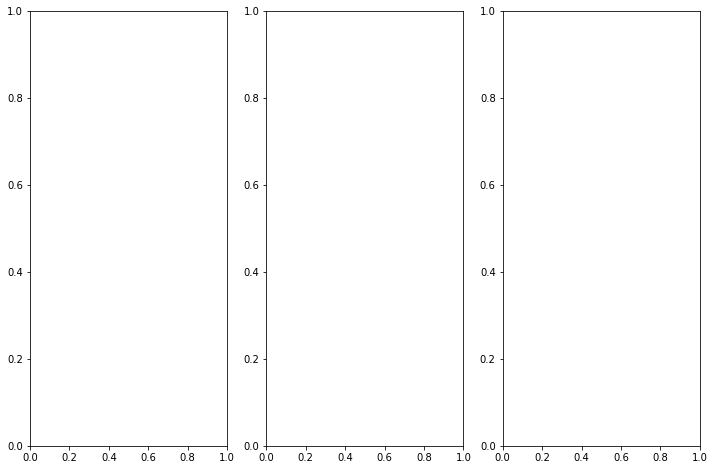

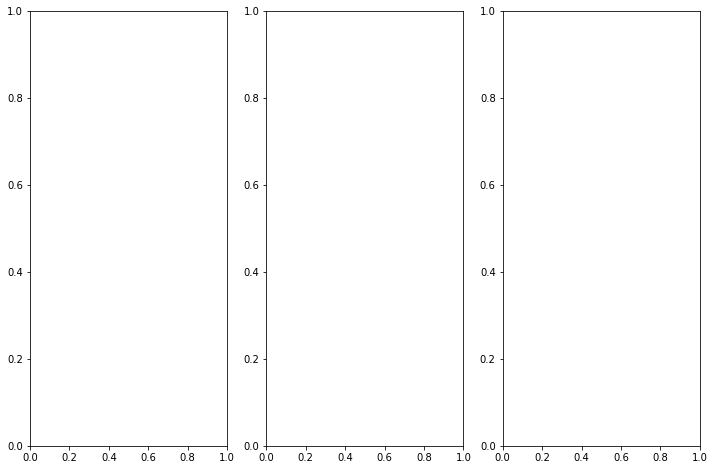

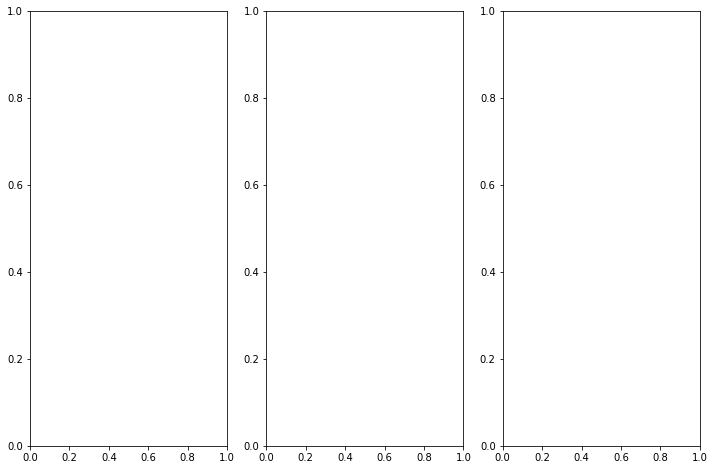

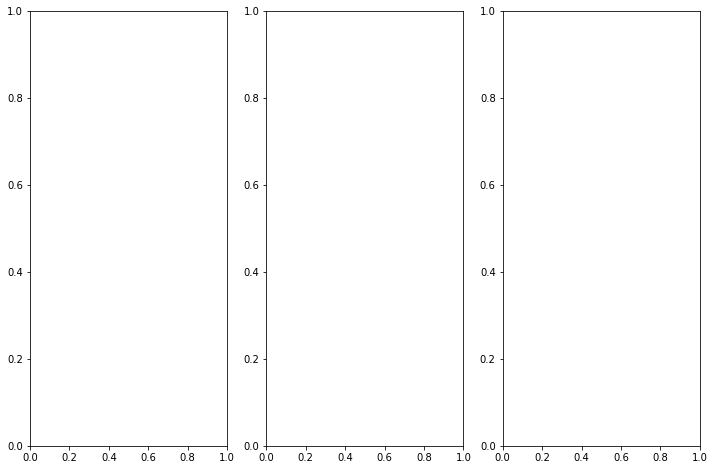

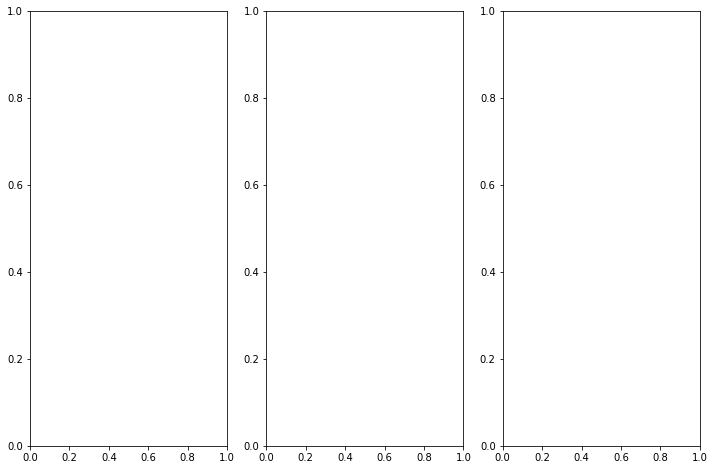

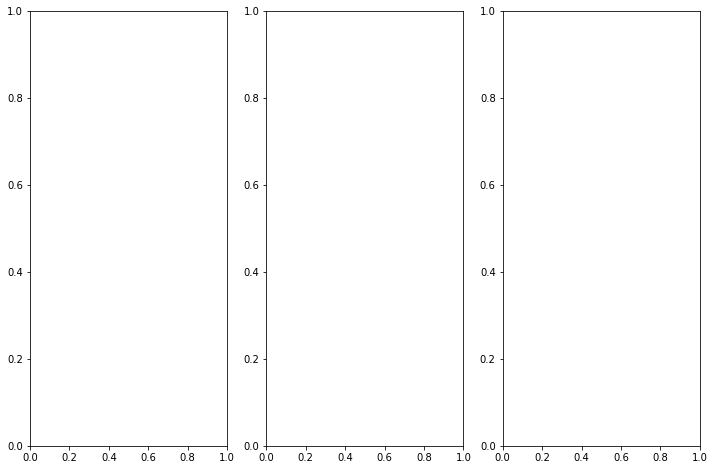

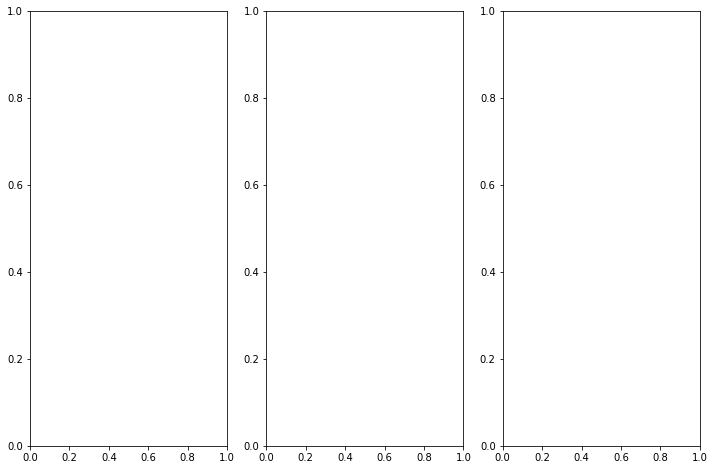

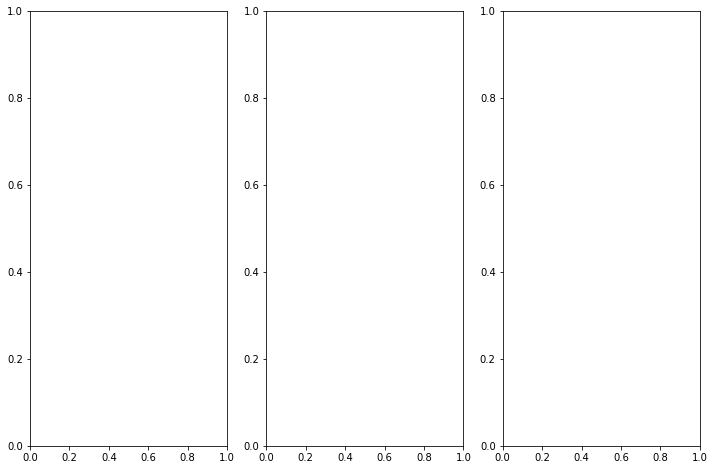

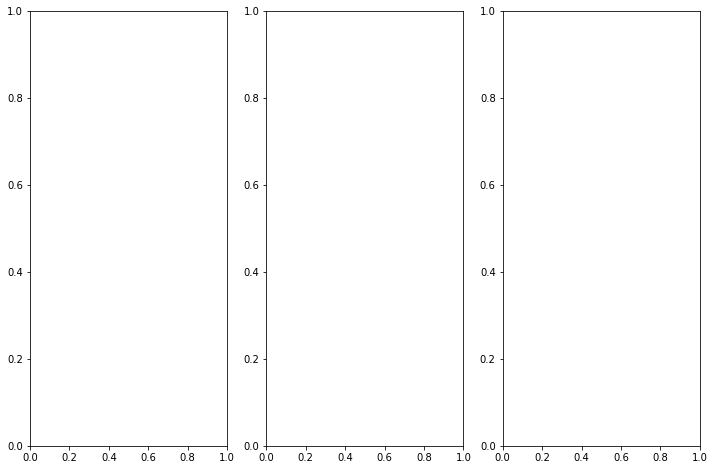

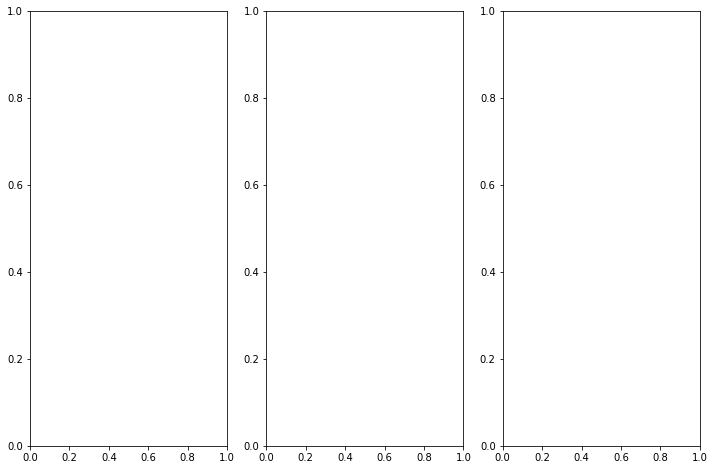

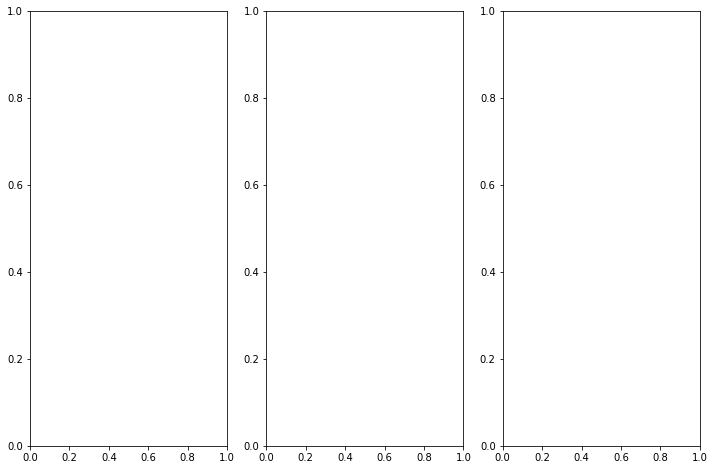

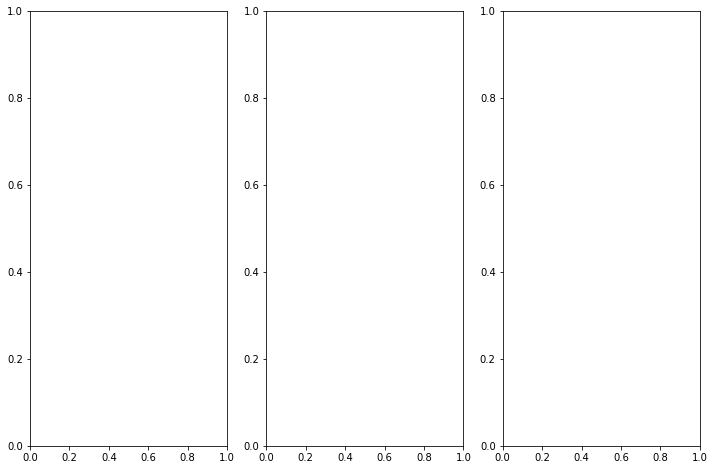

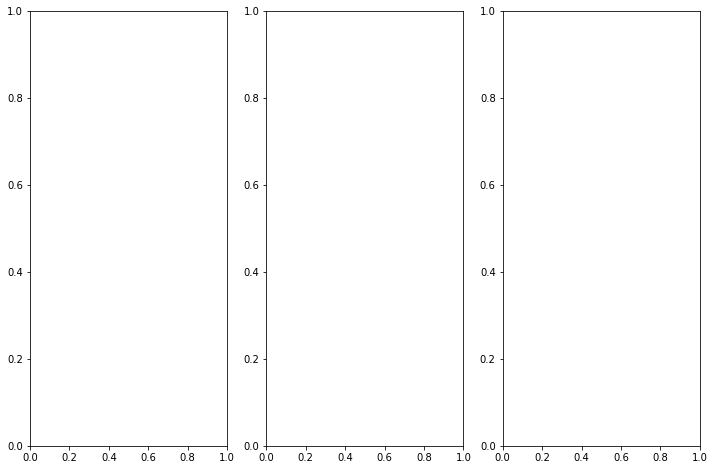

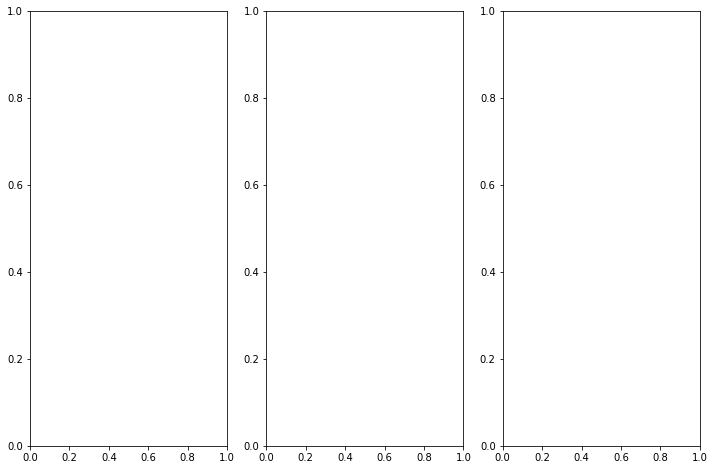

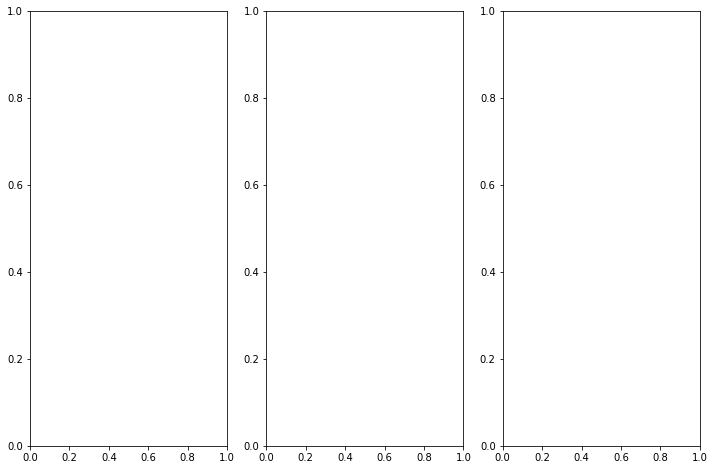

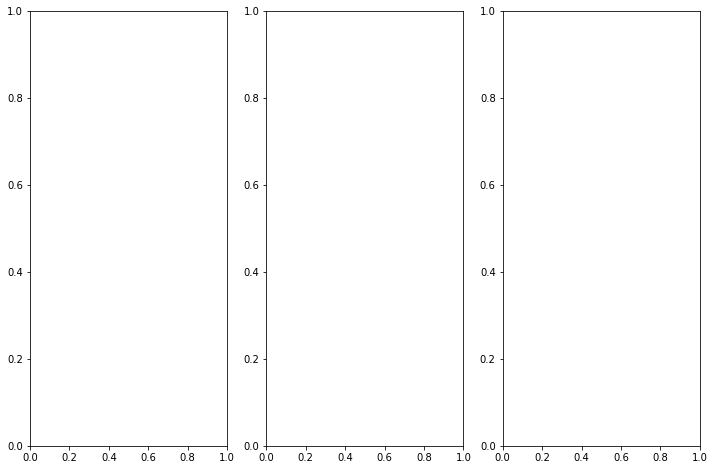

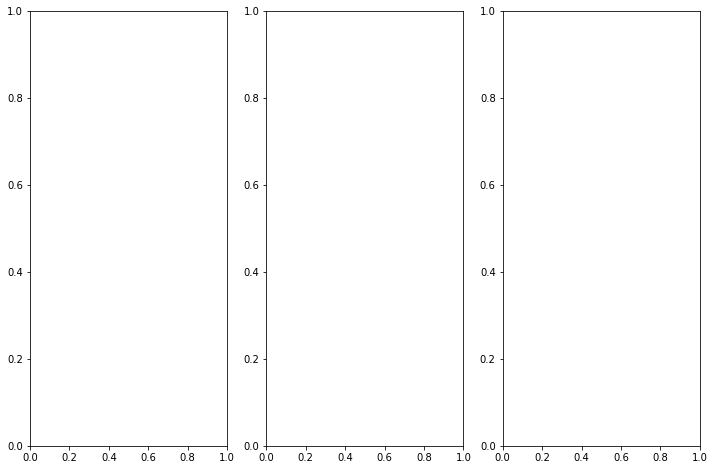

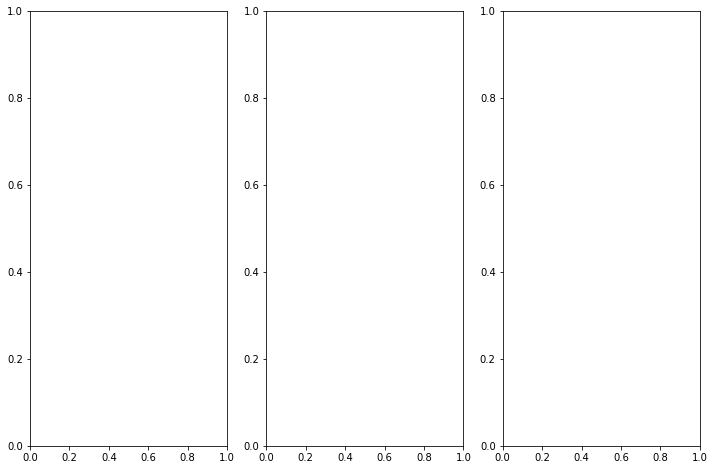

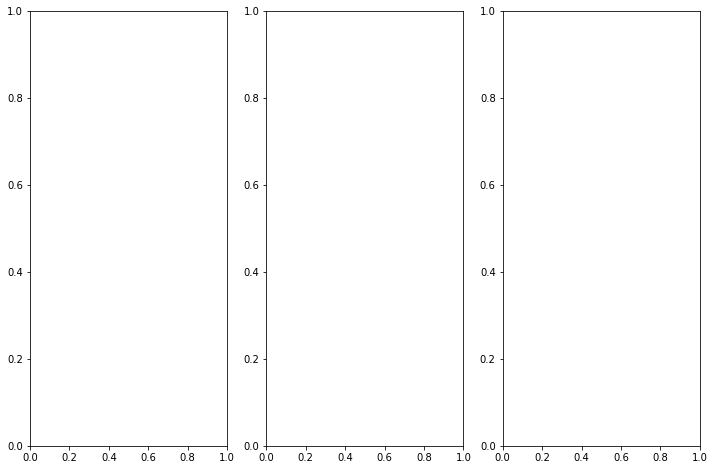

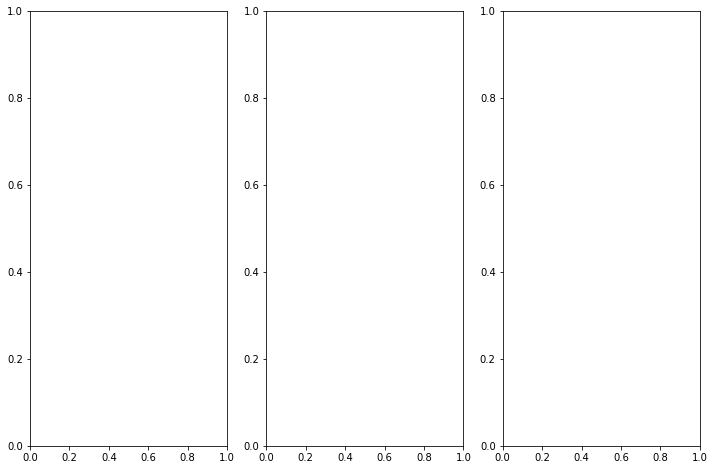

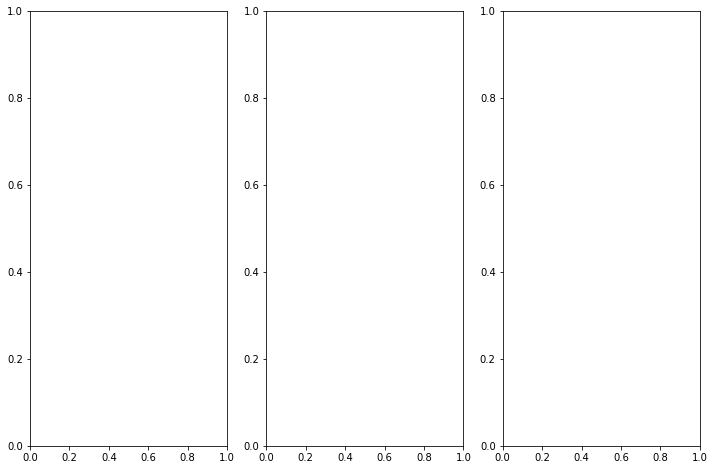

In [23]:
# モデルの定義
model = networks.UNet()
model = torch.nn.DataParallel(model, device_ids=range(torch.cuda.device_count()))
model = model.to("cuda")

# optimizerの準備
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0005)

# 誤差関数の定義
criterion = lf.BCEDiceLoss()
#criterion = nn.CrossEntropyLoss()

# 訓練ループ

train_loss_list = []
val_loss_list = []

for epoch in range(epoch_n):
    train_loss_add = 0
    model.train()
    for i, data in enumerate(train_loader):
        x, t = data
        x = torch.tensor(x)
        t = torch.tensor(t).float()
        
        x = x.to("cuda")
        t = t.to("cuda")
        
        predict = model(x)
        
        loss = criterion(predict, t)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss_add += loss.data
        model.eval()
        demo_pred = model(demo_img)
        demo_pred = demo_pred[3].to("cpu").detach().numpy().copy() * 255
        plt.imsave("../result/predicted_imgs/iter_" + str(epoch * (int(train_size/batchsize)) + i) +".png", np.rot90(demo_pred[0]), cmap="gray")
        model.train()
        
    loss_mean = train_loss_add / int(train_size/batchsize)
    print("epoch" + str(epoch+1))
    print("train_loss:" + str(loss_mean))
    train_loss_list.append(loss_mean)
    
    # validation
    model.eval()
    val_loss_add = 0
    num = 0
    for i, data in enumerate(val_loader):
            
        #cudaに変換
        x, t = data
        x = torch.tensor(x)
        t = torch.tensor(t).float()
        x = x.to("cuda")
        t = t.to("cuda")
        predict = model(x)
        
        loss = criterion(predict, t)
        val_loss_add += loss.data
    n_data = 6
    row = 1
    col = 3

    fig, ax = plt.subplots(nrows=row, ncols=col, figsize=(12,8))

    #fig.suptitle("学習経過")
    
    #img_x = x[3].to("cpu").detach().numpy().copy()
    #img_t = t[3].to("cpu").detach().numpy().copy()
    #pred = predict[3].to("cpu").detach().numpy().copy() * 255

#     ax[0].set_title("raw_image")
#     ax[0].axes.xaxis.set_visible(False)
#     ax[0].axes.yaxis.set_visible(False)
#     ax[0].imshow(img_x[0], cmap="gray")

#     ax[1].set_title("target")
#     ax[1].axes.xaxis.set_visible(False)
#     ax[1].axes.yaxis.set_visible(False)
#     ax[1].imshow(img_t[0], cmap="gray")

#     ax[2].set_title("predict")
#     ax[2].axes.xaxis.set_visible(False)
#     ax[2].axes.yaxis.set_visible(False)
#     ax[2].imshow(pred[0], cmap="gray")
#    plt.savefig("../result/demo/epoch_" + str(epoch+1) + ".png")
#    plt.imsave("../result/predicted_imgs/epoch_" + str(epoch+1) + ".png", np.rot90(pred[0]), cmap="gray")
    loss_mean = val_loss_add / int(val_size/batchsize)
    val_loss_list.append(loss_mean)
    print("val_loss:" + str(loss_mean))

In [4]:
x.shape

torch.Size([8, 1, 512, 512])

In [5]:
img_x = x[3].to("cpu").detach().numpy().copy()
img_t = t[3].to("cpu").detach().numpy().copy()
pred = predict[3].to("cpu").detach().numpy().copy() * 255

In [6]:
import matplotlib.pyplot as plt

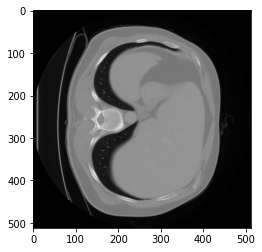

In [7]:
plt.imshow(img_x[0], cmap="gray")

In [8]:
x[3].shape

torch.Size([1, 512, 512])

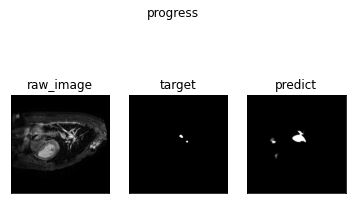

In [18]:
n_data = 6
row = 1
col = 3

fig, ax = plt.subplots(nrows=row, ncols=col)

fig.suptitle("progress")

ax[0].set_title("raw_image")
ax[0].axes.xaxis.set_visible(False)
ax[0].axes.yaxis.set_visible(False)
ax[0].imshow(img_x[0], cmap="gray")

ax[1].set_title("target")
ax[1].axes.xaxis.set_visible(False)
ax[1].axes.yaxis.set_visible(False)
ax[1].imshow(img_t[0], cmap="gray")

ax[2].set_title("predict")
ax[2].axes.xaxis.set_visible(False)
ax[2].axes.yaxis.set_visible(False)
ax[2].imshow(pred[0], cmap="gray")

In [9]:
len(heart_train)

943

In [16]:
zero = np.zeros((10, 1, 30, 30))
zero[2] = np.ones((1, 30, 30))
zero[5] = np.ones((1, 30, 30))

In [39]:
zero[:].shape

(10, 1, 30, 30)

In [32]:
np.delete(zero, np.all(zero == 0)[0], axis=0)

IndexError: invalid index to scalar variable.

In [28]:
zero.shape

(10, 1, 30, 30)

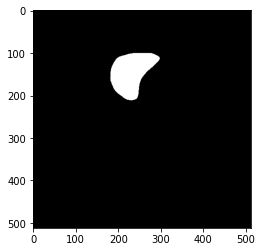

In [25]:
plt.imshow(img_t[0], cmap="gray")
plt.imsave("../result/target_img.png", np.rot90(img_t[0]), cmap="gray")

In [15]:
p = model(x)

In [11]:
demo_img = x.detach()

In [12]:
demo_img.shape

torch.Size([8, 1, 512, 512])

In [13]:
demo_img[3]

tensor([[[-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
         [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
         [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
         ...,
         [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
         [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
         [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.]]],
       device='cuda:0')

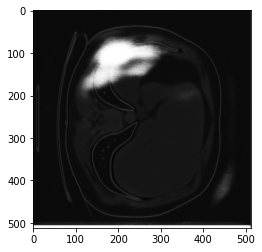

In [17]:
a = model(demo_img)
p = a[3].to("cpu").detach().numpy().copy() * 255
plt.imshow(p[0], cmap="gray")